In [1]:
import sys
print(sys.executable)


/opt/anaconda3/envs/COMP647_env_py312/bin/python


- Student Name: Xiuwen (Alice) Zhu
- Student ID: 1149188
- Course Code: COMP647
- Course Examiner: Professor Don Kulasiri
- Due Date: 08/09/2025

# Project Plan

- Columns to keep or drop
    - Columns to keep are: "uniq_id", "product_name", "price", "number_available_in_stock", "number_of_reviews", "average_review_rating", "amazon_category_and_sub_category", "product_information", "customer_reviews" and "seller".
    - I will drop "manufacturer" because it contains too much random and inaccurate information, such as numbers or repeated words from the product name, which makes it impossible to clean. 
    - I will drop "number_of_answered_questions" since the numbers don’t give any meaningful insight (the actual questions are unknown).
    - I will drop "customers_who_bought_this_item_also_bought" and "items_customers_buy_after_viewing_this_item" because they only contain product web links, and most of them are likely invalid as the dataset is quite old.
    - I will drop "description" and "product_description" because they are long paragraphs with similar content, and it is hard to extract clear, representative keywords from them.
    - I will drop "customer_questions_and_answers" because only 914 out of 10,000 rows are filled, and the filled ones contain long paragraphs that are difficult to handle.

- Clean data 
    - For "price", remove symbols before the number.
    - For "number_available_in_stock", split into two columns: "stock_quantity" and "stock_status".
    - From "average_review_rating", extract the numeric part into a new column called "average_rating".
    - For "amazon_category_and_sub_category", split into two levels only, and label them "main_category" and "sub_category".
    - From "product_information", extract product weight (e.g., values like weight…g or weight…kg) into a new column called "product_weight".
    - For "product_weight":
        - extract only numbers and g/kg,
        - convert all g values into kg,
        - remove the unit (e.g., kg).
    - From "product_information", also extract age suitability (e.g., age…up) into a new column called "age_suitability", and keep only the numeric part.
    - From "customer_reviews", extract the first date into a new column called "purchase_date" (assuming reviews were made in the same month as purchase).
    - From "seller", extract only the seller name.
    - Fix the data type for each feature.
    - For all string columns, use .strip() to remove leading and trailing spaces.
    - Drop the original features after transformation.


- Transform data
    - Filling missing value
        - For categories, use "Unknown main category" and "Unknown sub category".
        - For "price", fill with the average price of the same sub_category.
        - For "stock_quantity", fill with the mode of the same sub_category.
        - For "stock_status", fill with the mode of the same sub_category.
        - For "product_weight", fill with the median of the same sub_category.
        - For "age_suitability", fill with the mode of the same sub_category.
        - For "purchase_date", fill with the mode of the same sub_category.
        - For "number_of_reviews", fill with the mode of the same sub_category.
        - For "average_rating", fill with the average rating of the same sub_category.
        - For "seller", fill with "Unknown seller".


- Visualise data
    - Plotting for EDA
    - Feature Engineering
    - Machine Learning Models

# Research Questions

**As an entrepreneur, I want to know:**
1. Which main product category tends to receive a higheest number of reviews and highest average rating? (assuming that higher product ratings reflect better sales performance)
2. Within that main category, which sub-category will sell best based on their current reviews and ratings?
3. What is the minimum unit quantity I should prepare to start a business based on avalable stock quantities?


**As a buyer, I want to know:**

4. Which seller offers the cheapest price for the same product?
5. Which sellers have received more consistent high ratings for their products?


**As the company, I want to know:**

6. Which month of the year had the highest sales?
7. Which year recorded the highest purchase activity and which main product categories did most purchases come?
8. What are the main factors of the sold products that may be contributing to the variation in sales?



# Import the Necessary Libraries for Data Cleaning

In [2]:
import numpy as np # Numerical operations and array handling.
import pandas as pd # Data manipulation and analysis.
import seaborn as sns
import sklearn # Machine learning library for Python.
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import calendar
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder  # Encoding categorical features as numerical values.
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree   # import the module
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.tree import _tree
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats # Module for scientific computing, including statistical functions.
from adjustText import adjust_text
import re # Regular expressions for string matching and manipulation.





# Read Data from CSV

Data source: [Fashion products on Amazon.com](https://www.kaggle.com/datasets/hkhamnakhalid/fashion-products-on-amazoncom)

In [3]:
file_path = 'amazon_co-ecommerce_sample.csv' # Define the file path for the dataset.
df = pd.read_csv (file_path) # Read the csv file into a DataFrame.

# Understand Data

In [4]:
df[df.groupby('product_name')['product_name'].transform('count') > 1] 
# The .groupby function allows to aggregate the data occurance. 
# The .transform('count') > 1 will call out data under the product name occur more than once.
# The intention of this move

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
71,1e9876e6f7e98a6bb869341b4b56efd5,Power Trains Auto Loader City,POWER CITY TRAINS,£76.99,2 new,NaN,1.0,NaN,NaN,http://www.amazon.co.uk/Power-Trains-Auto-Load...,Power City Trains Auto Loader City,Technical Details Item Weight1.5 Kg Product Di...,Power City Trains Auto Loader City,http://www.amazon.co.uk/Power-Trains-Auto-Load...,NaN,NaN,"{""seller""=>[{""Seller_name_1""=>""Eurozone Market..."
411,b585918cbbf998a288bbb259313f0296,Polyhedral Dice,Chessex,£11.93,4 new,1,1.0,5.0 out of 5 stars,Games > Dice & Dice Games,http://www.amazon.co.uk/Polyhedral,Signature dice are a compilation of the best s...,Technical Details Item Weight54 g Product Dime...,Signature dice are a compilation of the best s...,NaN,NaN,RPG-tastic! // 5.0 // 21 April 2013 // By\n ...,NaN
441,47e284cab850f3a73f412ed5fe85d969,"100 six sided dice, 14mm, random colours",The Dice Place,£10.79,NaN,1,1.0,5.0 out of 5 stars,Games > Dice & Dice Games,http://www.amazon.co.uk/Chessex-Dice-Pound-Pou...,A pack of 100 (minimum) dice useful for many b...,Technical Details Item Weight277 g Product Dim...,A pack of 100 (minimum) dice useful for many b...,http://www.amazon.co.uk/sided-dice-16mm-random...,NaN,Five Stars // 5.0 // 19 Feb. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""Legendgames"", ""S..."
471,b5b9d9641ddd0c677c5ddaa719207f63,Polyhedral Dice,Chessex,£9.74,2 new,1,1.0,5.0 out of 5 stars,Games > Dice & Dice Games,http://www.amazon.co.uk/WHATWEARS-Poly-Dices-P...,NaN,Technical Details Item Weight54 g Manufacturer...,NaN,NaN,NaN,"Good design and good quality, would recommend....",NaN
585,222285fb1f28be6b3d6d14d5c35e562f,"100 six sided dice, 14mm, random colours",The Dice Place,£10.79,NaN,2,1.0,5.0 out of 5 stars,Games > Dice & Dice Games,http://www.amazon.co.uk/spot-12mm-diameter-ass...,A pack of 100 (minimum) dice useful for many b...,Technical Details Item Weight277 g Product Dim...,A pack of 100 (minimum) dice useful for many b...,http://www.amazon.co.uk/spot-12mm-diameter-ass...,NaN,I now have want more // 5.0 // 7 Mar. 2013 // ...,"{""seller""=>{""Seller_name_1""=>""Legendgames"", ""S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9250,0046d3f852f55ee28b4a049ed387a946,Orchard Toys Farmyard Dominoes,Orchard Toys,£7.99,21 new,19,5.0,4.8 out of 5 stars,Games > Educational Games,http://www.amazon.co.uk/Orchard-Toys-28-Farm-S...,Product Description This is the familiar game ...,Technical Details Item Weight572 g Product Dim...,Product Description This is the familiar game ...,http://www.amazon.co.uk/Orchard-Toys-Old-MacDo...,NaN,brilliant // 5.0 // 15 May 2012 // By\n \n ...,"{""seller""=>[{""Seller_name_1""=>""Atrad"", ""Seller..."
9449,0cf2e89e32c4729f71647e876cbb5dec,20Q,Mattel,NaN,NaN,34,1.0,4.4 out of 5 stars,Electronic Toys > Educational Computers & Acce...,http://www.amazon.co.uk/An-Astronauts | http:/...,Product Description I have mixed the bar-codes...,Technical Details Item Weight222 g Product Dim...,Product Description I have mixed the bar-codes...,http://www.amazon.co.uk/Radica-I4012-20Q/dp/B0...,does the ball talk? // No displays answer on s...,I beg to differ // 4.0 // 27 Oct. 2010 // By\n...,NaN
9467,b7fb4625845f84ffc5b34fdc27189587,20Q,Radica,NaN,2 new,102,1.0,4.5 out of 5 stars,Games > Trivia & Quiz Games,http://www.amazon.co.uk/Radica-I6088-20Q-Versi...,Product Description I can read your mind! Manu...,Technical Details Item Weight91 g Product Dime...,Product Description I can read your mind! Manu...,http://www.amazon.co.uk/Radica-I6088-20Q-Versi...,NaN,"Great, but a little bit spooky!! // 5.0 // 21 ...","{""seller""=>[{""Seller_name_1""=>""Smaller Worl

In [5]:
# Use DataWrangler to understand data quality issues. 
# This extension helps to identify missing values, duplicates, and other data quality issues by providing a summary and displaying data in a table format.
df.head(1)

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."


# Keep Useful Columns Only

### All Columns in DataFrame

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uniq_id                                      10000 non-null  object 
 1   product_name                                 10000 non-null  object 
 2   manufacturer                                 9993 non-null   object 
 3   price                                        8565 non-null   object 
 4   number_available_in_stock                    7500 non-null   object 
 5   number_of_reviews                            9982 non-null   object 
 6   number_of_answered_questions                 9235 non-null   float64
 7   average_review_rating                        9982 non-null   object 
 8   amazon_category_and_sub_category             9310 non-null   object 
 9   customers_who_bought_this_item_also_bought   8938 non-null   object 
 10 

### All Columns in Cleaned DataFrame

In [7]:
cleaned_df=df[[
    'uniq_id',
    'product_name',
    'price',
    'number_available_in_stock',
    'number_of_reviews',
    'average_review_rating',
    'amazon_category_and_sub_category',
    'product_information',
    'customer_reviews',
    'sellers']]

In [8]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   uniq_id                           10000 non-null  object
 1   product_name                      10000 non-null  object
 2   price                             8565 non-null   object
 3   number_available_in_stock         7500 non-null   object
 4   number_of_reviews                 9982 non-null   object
 5   average_review_rating             9982 non-null   object
 6   amazon_category_and_sub_category  9310 non-null   object
 7   product_information               9942 non-null   object
 8   customer_reviews                  9979 non-null   object
 9   sellers                           6918 non-null   object
dtypes: object(10)
memory usage: 781.4+ KB


# Reformat Columns

## Remove Symbols in "price" Column

In [9]:
# Although it is obvious that this column contains money symbol, but it could also contain other characters that I oversee. 
# So, instead of droping the things I don't want, I will extract the things I want.

cleaned_df['cleaned_price'] = (
    cleaned_df['price']
    .astype(str)  # change the datatype to string
    .str.extract(r'(\d+\.\d+|\d+)')  # From the string, extract only the numeric vaules using regular expression
    #(r'\d+\.\d+|\d+') this regex pattern matches both integer and decimal numbers.
    .astype(float) )

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_99583/2785400651.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['cleaned_price'] = (


In [10]:
cleaned_df.info()
cleaned_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
dtypes: float64(1), object(10)
memory usage: 859.5+ KB


,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,cleaned_price
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.99
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",9.99


## Split values in "number_available_in_stock" Column

In [11]:
# This column contains both integer and string values. I will first extract the integer values, then convert them to numeric datatype.

cleaned_df['stock_quantity'] = (
    cleaned_df['number_available_in_stock']
    .str.extract(r'(\d+)')   # Using the regular expression (r'\d+') to capture the integer numbers.
    .astype('Int64')) # I tried using 'int', but it didn't work because 'int' can only be used when there are no missing values or NaN. 
    # So, I used 'Int64' instead, and it worked. 'Int64' can handle the presence of missing value and NaN values.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_99583/2153675905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['stock_quantity'] = (


In [12]:
# After extracting the numerical values, I will extract the string values to another new column.

cleaned_df['stock_condition'] = (
    cleaned_df['number_available_in_stock']
    .str.extract(r'\d+\s*(.*)')[0]  
    #  \d+ represents any digit before the space.
    #  \s* represents any space between the digit and the string.
    #  (.*) extract everything after the space, which is the string part.
    .str.strip()) 


/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_99583/741352323.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['stock_condition'] = (


In [13]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  stock_quantity                    7500 non-null   Int64  
 12  stock

## Extract Numerical Data from "average_review_rating" and Correct Data Type

In [14]:
cleaned_df['average_review_rating_out_of_5'] = (# Create a new column 'average_rating_out_of_5.0' in cleaned_df for cleaned average review ratings.
    cleaned_df['average_review_rating'] 
    .astype(str) # Convert to string to handle any NaNs, as explained in the previous steps.
    .str.extract(r'(\d+\.\d+|\d+)', expand=False)  
    # (\d+ extracts one or more digits. Eg: '123', '4567', '89'.
    # \.\d+ extracts a decimal point followed by one or more digits. Eg: '3.5', '4.0', '2.75'.
    # | extracts ither an integer (\d+) or a float (\d+\.\d+).
    # expand=False ensures that the result is a Series, not a DataFrame. Eg: '123.45' will be extracted as a single value, not as 1, 2, 3 . 4 and 5 in individual columns.
    .astype(float)
 ) # Convert to float.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_99583/3933719750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['average_review_rating_out_of_5'] = (# Create a new column 'average_rating_out_of_5.0' in cleaned_df for cleaned average review ratings.


In [15]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  stock_quantity                    7500 non-null   Int64  
 12  stock

## Split Product Hierachy for "amazon_category_and_sub_category" Column


In [16]:
# The reason to keep two levels of the hierachy only is because many of the category level stopped after two levels. 

cleaned_df[['main_category', 'sub_category']] = (
    df['amazon_category_and_sub_category']
    .str.split('>', expand=True)[[0, 1]])
# The .str.split('>') function splits the string into a list of substrings based on the '>'.
# The expand=True function specifies the split data to expand to its new column, not within the original column. 
# The [[0,1]] function specifies to select the first and second from the hierachy list only.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_99583/127122190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[['main_category', 'sub_category']] = (
/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_99583/127122190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[['main_category', 'sub_category']] = (


In [17]:
cleaned_df.info()
# The row count of the two new columns are same as the original. This means good.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  stock_quantity                    7500 non-null   Int64  
 12  stock

In [18]:
cleaned_df.head(3)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.99,<NA>,NaN,4.5,Hobbies,Model Trains & Railway Sets
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",9.99,2,new,3.9,Hobbies,Model Trains & Railway Sets


In [19]:
print(cleaned_df['main_category'].value_counts(dropna=False)) 
# This function allows me to see the count of each category, including the missing value.

main_category
Hobbies                              1464
Die-Cast & Toy Vehicles              1221
Figures & Playsets                   1111
Characters & Brands                   960
Games                                 941
Arts & Crafts                         802
Party Supplies                        694
NaN                                   690
Fancy Dress                           585
Sports Toys & Outdoor                 372
Dolls & Accessories                   371
Jigsaws & Puzzles                     274
Puppets & Puppet Theatres             269
Baby & Toddler Toys                   106
Pretend Play                           45
Musical Toy Instruments                19
Novelty & Special Use                  11
Pens, Pencils & Writing Supplies        7
Office Supplies                         6
Electronic Toys                         5
Home Accessories                        5
Bags                                    4
Cooking & Dining                        4
Educational Toys    

In [20]:
print(cleaned_df['sub_category'].value_counts(dropna=False)) 

sub_category
 Toy Vehicles & Accessories          1100
NaN                                   690
 Science Fiction & Fantasy            485
 Accessories                          388
 Model Trains & Railway Sets          386
                                     ... 
 Transportation & Traffic               1
 Specialty & Decorative Lighting        1
 Instruments                            1
 Trading Cards & Accessories            1
 Drinking Games                         1
Name: count, Length: 166, dtype: int64


## Extract Values from "product_information" Column

### Extract Item Weight

In [21]:
# This column has a lot of mixed information, but I only want to extract two things. They are the item weight (for logistics) and the recommended age (for buyer reference).

cleaned_df['item_weight'] = cleaned_df['product_information'].str.extract(r'Item Weight\s*([\d\.]+\s*(?:g|Kg))', 
    expand=False)

# Regular expression is used to exract the item weight, with \s* allows for space between the word item and weight.
# ([\d\.]+ specifies extracting value with one or more digits or decimal point.
# \s* allows for space after the value.
# (?:g|Kg) specifies the unit can either be g or kg.
# The entire expression within the bracket indicates to only return the weight value plus unit.

In [22]:
# I want the unit within the column to be consistent for better data reviewing. 

def convert_to_kg(value): # This def instruction defines what I want python to do with "convert_to_kg".
    if pd.isna(value):  # if value is missing, just return NaN
        return None
    value = value.strip() 
    if value.endswith("Kg"): # if values end with kg
        return float(value.replace("Kg", "").strip()) # return only a decimal value and replace the kg with whitespace.
    elif value.endswith("g"): # if values ends with g
        return float(value.replace("g", "").strip()) / 1000 # return only a decimal value that divided by 1000 and replace the g with whitespace.
    else:
        return None
    
cleaned_df['item_weight'] = cleaned_df['item_weight'].apply(convert_to_kg)
# By applying the defined instruction that has been explained to python, I want it to apply this expression to the "item_weight" column to remove the unit and make everything numeric in kilograms.

In [23]:
# Rename the column to reflect the unit.
cleaned_df.rename(columns={'item_weight': 'item_weight_in_kg'}, inplace=True)

In [24]:
cleaned_df.head(3)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.99,<NA>,NaN,4.5,Hobbies,Model Trains & Railway Sets,NaN
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",9.99,2,new,3.9,Hobbies,Model Trains & Railway Sets,NaN


### Extract Recommended Age

In [25]:
# First, extract the manufacturer recommended age from the product_information column.

age_extracted = cleaned_df['product_information'].str.extract(
    r'Manufacturer recommended age:(\d+)\s*(years|months)',
    expand=True)  


In [26]:
age_value = pd.to_numeric(age_extracted[0], errors='coerce')
age_unit = age_extracted[1]

In [27]:
cleaned_df['recommended_minimum_age_years'] = np.where(
    age_unit == 'months',
    age_value / 12,   # months → years
    age_value).round(2)  # already in years


In [28]:
cleaned_df.head(3)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.99,<NA>,NaN,4.5,Hobbies,Model Trains & Railway Sets,NaN,3.0
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",9.99,2,new,3.9,Hobbies,Model Trains & Railway Sets,NaN,3.0


## Extract Date from "customer_reviews"

In [29]:
# This dataset doesn't have a purchase date column. 
# So I will extract the first date from the customer_reviews to simulate the purchase date, as assuming the the review is within a month of the purchase.

date_extract = cleaned_df['customer_reviews'].str.extract(r'\b(?:[1-9]|[12][0-9]|3[01])\s+([A-Za-z]+)\.?\s+(\d{4})')

# \b represents a boundry of a word or number to ensure that we are matching the day at the start of the date.
# (?:[1-9]|[12][0-9]|3[01]) represents matching day values from 1 to 31.
# \s represents space and the + represents one or more.
# ([A-Za-z]+\.?) represents month. Extracting either 'Nov.' or 'April'.
# (\d{4}) represents year in four digits.

In [30]:
# Allocating the extracted month and year to two new columns and standardising the month column.

cleaned_df['purchase_month'] = date_extract[0] # Capture month first to a new column.
cleaned_df['purchase_month'] = cleaned_df['purchase_month'].str.replace(r'\.', '', regex=True) 
# Remove any dots like in 'Nov.' to make it 'Nov'.

month_map = {
    'January': 'Jan', 'Jan': 'Jan',
    'February': 'Feb', 'Feb': 'Feb',
    'March': 'Mar', 'Mar': 'Mar',
    'April': 'Apr', 'Apr': 'Apr',
    'May': 'May',
    'June': 'Jun', 'Jun': 'Jun',
    'July': 'Jul', 'Jul': 'Jul',
    'August': 'Aug', 'Aug': 'Aug',
    'September': 'Sep', 'Sept': 'Sep', 'Sep': 'Sep',
    'October': 'Oct', 'Oct': 'Oct',
    'November': 'Nov', 'Nov': 'Nov',
    'December': 'Dec', 'Dec': 'Dec'}

cleaned_df['purchase_month'] = cleaned_df['purchase_month'].map(month_map)


cleaned_df['purchase_year'] = date_extract[1].astype('Int64') # Capture year subsequently to another new column.

In [31]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  stock_quantity                    7500 non-null   Int64  
 12  stock

In [32]:
print(cleaned_df['purchase_month'].unique())

# I noticed that that the extracted month row count is 9278, less than the customer_reviews row count. 
# However, the purchase_year row count is the same as the customer_reviews row count.
# So, I want to check the unique values in the purchase_month column to see what is there.

['Apr' 'Dec' 'May' 'Jul' 'Oct' 'Jan' 'Nov' 'Feb' 'Aug' 'Mar' 'Jun' 'Sep'
 nan]


In [33]:
missing_months = cleaned_df[cleaned_df['purchase_year'].notna() & cleaned_df['purchase_month'].isna()]
# The .notna() function checks for non-missing values in the purchase_year column.
# The .isna() function checks for missing values in the purchase_month column.

# This function demonstrates which rows had the year but no month extracted.
# From this I saw that some months were recorded in a weird format like Sept, while others are like Sep or September, causing confusion to the regex extraction.
# I fixed the month mapping above, then I re-run the code and the row count was 9978. However, this is still one less than the customer_reviews row count of 9979.
# The issue was that in one of the rows, there was a 4-digit number just before the day, month and year, causing the regex to confuse and fail extract this row.
# I fixed the issue by going back to step 1 to alter the regex to be even more flexible.

print(missing_months['customer_reviews'].head(20))

Series([], Name: customer_reviews, dtype: object)


In [34]:
# Now, I will convert the cleaned calendar month into numerical calender. This should make subsequent analysis easier.

cleaned_df['purchase_month'] = cleaned_df['purchase_month'].apply(
    lambda x: list(calendar.month_abbr).index(x[:3].title()) if isinstance(x, str) else x).astype('Int64')


## Extract Seller Name from "sellers" Column

In [35]:
cleaned_df['seller_name'] = (
    cleaned_df['sellers'].str.extract(r'"Seller_name_1"=>\"([^"]+)"'))  

# "Seller_name_1"=>\", this part is how the data was structured in the original column. Within this regex, it means find the data after this pattern.
# The ([^"]+) means capture everything between the quotes.

In [36]:
def clean_seller_name(name):
    if pd.isna(name):
        return name
    # 1. Remove text in parentheses.
    name = re.sub(r"\(.*?\)", "", name) # remove (...) blocks
    name = re.sub(r'\s*\[.*?\]', '', name) # remove [...] blocks
    
    # 2. Remove text after symbols.
    name = re.split(r'\s*[-–—]{1,2}\s*', name)[0] # Remove text after " — " or " -- " or " --- "
    name = re.split(r'[|*]', name)[0] # Remove text after | or *
    return name.strip()

In [37]:
# After reviewing the data manually, I noticed some seller names have a very different pattern. 
# The name and extra information like advertisement, logistics, etc are not separated by any punctuations or symbols.
# So, the Heuristic trimming is used to remove any text following the presence of the listed stop words.

stop_words = ["free", "uk", "delivery", "dispatch", "ship", "supply", 
              "days", "arrive", "ignore", "estimates", "order", "p&p", 
              "authorised", "mainland", "seller"]


In [38]:
def heuristic_trim(name):
    words = name.split()
    cleaned = []
    for w in words: # Go through each word in the name that has been split in prior step.
        if w.lower() in stop_words: # Convert the word to lowercase so that it is not case sensitive during matching. If a stop word is found,
            break # Cut off the rest of the text.
        cleaned.append(w) # If the word is not a stop word, keep it.
    return " ".join(cleaned).strip() # Join back the split cleaned words as the seller name.

cleaned_df['seller_name'] = cleaned_df['seller_name'].astype(str).apply(lambda x: heuristic_trim(clean_seller_name(x)))

In [39]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  stock_quantity                    7500 non-null   Int64  
 12  stock

In [40]:
cleaned_df.head(3)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,...,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",...,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0,4,2014,Amazon.co.uk
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",...,<NA>,NaN,4.5,Hobbies,Model Trains & Railway Sets,NaN,3.0,12,2015,UHD WHOLESALE
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",...,2,new,3.9,Hobbies,Model Trains & Railway Sets,NaN,3.0,5,2015,DEAL


## Apply Strip () to All Str Type Columns

In [41]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  stock_quantity                    7500 non-null   Int64  
 12  stock

In [42]:
for col in cleaned_df.select_dtypes(include='object').columns:
    cleaned_df[col] = cleaned_df[col].str.strip()

## Drop Original Columns

In [43]:
cleaned_df.drop(columns=['price','number_available_in_stock','average_review_rating',
                         'amazon_category_and_sub_category','product_information','customer_reviews','sellers'], inplace=True)  
# Drop the original column after extracting the main category.

In [44]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         10000 non-null  object 
 1   product_name                    10000 non-null  object 
 2   number_of_reviews               9982 non-null   object 
 3   cleaned_price                   8565 non-null   float64
 4   stock_quantity                  7500 non-null   Int64  
 5   stock_condition                 7500 non-null   object 
 6   average_review_rating_out_of_5  9982 non-null   float64
 7   main_category                   9310 non-null   object 
 8   sub_category                    9310 non-null   object 
 9   item_weight_in_kg               7752 non-null   float64
 10  recommended_minimum_age_years   8718 non-null   float64
 11  purchase_month                  9979 non-null   Int64  
 12  purchase_year                   9

# Filling Missing Values

## Fill in 'main_category'

In [45]:
cleaned_df['main_category'] = cleaned_df['main_category'].fillna('Unknown') # fillna() replaces NaN values with 'Unknown'.

## Fill in 'sub_ategory'

In [46]:
cleaned_df['sub_category'] = cleaned_df['sub_category'].fillna('Unknown') # fillna() replaces NaN values with 'Unknown'.

In [47]:
cleaned_df.head(1)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0,4,2014,Amazon.co.uk


## Fill in 'price'

In [48]:
cleaned_df['cleaned_price'] = (
    cleaned_df.groupby('sub_category')['cleaned_price']
    .transform(lambda x: x.fillna(x.mean()))).round(2)
# I group the sub_category with the cleaned_price to fill in the missing values using the average price of the same sub_category.
# However, I discovered that there are 2 rows with missing value. 
# These two rows contains numerous other missing values, thus I decide to drop these two rows later. 


In [49]:
cleaned_df.head(1)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0,4,2014,Amazon.co.uk


## Fill in 'stock_quantity'

In [50]:
# I initially tried to fill in using the (x.mode()), but it didnt work because it returned a series of frequent values, which is missing value. So the missing values remain missing.
# Then, I also discovered that some sub_categories only contain missing values.
# So, I decided that if the sub_category cannot be used to provide a mode value, then I will go up a level, use the main_category to fill in the missing values.

# Capture the mode values from each sub_category.
subcat_modes = (
    cleaned_df.groupby('sub_category')['stock_quantity']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None))
# .agg(lambda x:...) represents aggregating a small function to a group.
# x.mode() find the mode.
# .iloc[0] choose the first mode if there are multiple modes.
# if not x.mode().empty else None, this is when all the values in the group are missing, then return None.

In [51]:
# Capture the mode values from main_category.
maincat_modes = (
    cleaned_df.groupby('main_category')['stock_quantity']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None))

In [52]:
# Define a function for python to run.

def fill_with_mode(row):
    if pd.notna(row['stock_quantity']): # If the value is not NaN, then return as it is.
        return row['stock_quantity']
   
    # First, try fill in using the mode from sub_category.
    sub_mode = subcat_modes.get(row['sub_category'], None)
    if pd.notna(sub_mode):
        return sub_mode
    
    # When filling in mode values using sub_category fail, then use main_category to fill in.
    main_mode = maincat_modes.get(row['main_category'], None)
    if pd.notna(main_mode):
        return main_mode
   
    # If even that fails, just keep it NaN
    return np.nan


In [53]:
cleaned_df['stock_quantity'] = cleaned_df.apply(fill_with_mode, axis=1).astype('Int64')
# Apply the defined function.
# axis=1 means apply the function to row, while axis=0 means apply the function to column.

In [54]:
cleaned_df.head(1)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0,4,2014,Amazon.co.uk


## Fill in 'stock_condition'

In [55]:
subcat_modes = (
    cleaned_df.groupby('sub_category')['stock_condition']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None))

In [56]:
maincat_modes = (
    cleaned_df.groupby('main_category')['stock_condition']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None))

In [57]:
def fill_with_mode(row):
    if pd.notna(row['stock_condition']): # If the value is not NaN, then return as it is.
        return row['stock_condition']
   
    # First, try fill in using the mode from sub_category.
    sub_mode = subcat_modes.get(row['sub_category'], None)
    if pd.notna(sub_mode):
        return sub_mode
    
    # When filling in mode values using sub_category fail, then use main_category to fill in.
    main_mode = maincat_modes.get(row['main_category'], None)
    if pd.notna(main_mode):
        return main_mode
   
    # If even that fails, just keep it NaN
    return np.nan


cleaned_df['stock_condition'] = cleaned_df.apply(fill_with_mode, axis=1)

In [58]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         10000 non-null  object 
 1   product_name                    10000 non-null  object 
 2   number_of_reviews               9982 non-null   object 
 3   cleaned_price                   9989 non-null   float64
 4   stock_quantity                  9996 non-null   Int64  
 5   stock_condition                 9996 non-null   object 
 6   average_review_rating_out_of_5  9982 non-null   float64
 7   main_category                   10000 non-null  object 
 8   sub_category                    10000 non-null  object 
 9   item_weight_in_kg               7752 non-null   float64
 10  recommended_minimum_age_years   8718 non-null   float64
 11  purchase_month                  9979 non-null   Int64  
 12  purchase_year                   9

In [59]:
cleaned_df.head(1)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0,4,2014,Amazon.co.uk


## Fill in 'item_weight_in_kg'

In [60]:
# The reason to fill in the missing value using the median is because weight data is often skewed.
# So, if I use either mean or mode, will result in biased values.

cleaned_df['item_weight_in_kg'] = (
    cleaned_df.groupby('sub_category')['item_weight_in_kg']
    .transform(lambda x: x.fillna(x.median())))

In [61]:
# Missing values still exist after filling in using sub_category median.
# Since moving up a level to main_category can cause too much vairations, I won't do that.
# Instead, I will fill in the remainders with 0.0

cleaned_df['item_weight_in_kg'] = cleaned_df['item_weight_in_kg'].fillna(0.0).round(1)

In [62]:
cleaned_df.head(3)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,4,2014,Amazon.co.uk
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,2,16.99,3,new,4.5,Hobbies,Model Trains & Railway Sets,0.2,3.0,12,2015,UHD WHOLESALE
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,17,9.99,2,new,3.9,Hobbies,Model Trains & Railway Sets,0.2,3.0,5,2015,DEAL


## Fill in 'average_review_rating_out_of_5'

In [63]:
cleaned_df['average_review_rating_out_of_5'] = (
    cleaned_df.groupby('sub_category')['average_review_rating_out_of_5'] # .groupby() groups the DataFrame by 'amazon_category'and 'average_review_rating_out_of_5' columns.
    .transform(lambda x: x.fillna(x.mean()))).round(1) # .transform() applies a function to each group, filling NaN values with the mean of the group.
    # lambda x: x.fillna(x.mean()) calculates the mean of the group and fills NaN values with that mean.

In [64]:
cleaned_df.head(1)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,4,2014,Amazon.co.uk


## Fill in 'recommended_minimum_age_years'

In [65]:
# I learned that it is a good idea to use 2 levels fallback to fill in missing values.
# So, I will use this approach for this column as well.

# Calculate the modes for both levels.
sub_modes = cleaned_df.groupby("sub_category")["recommended_minimum_age_years"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
main_modes = cleaned_df.groupby("main_category")["recommended_minimum_age_years"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)

In [66]:
# Firstly, try to fill in using the sub_category mode.
cleaned_df['recommended_minimum_age_years'] = (
    cleaned_df.groupby('sub_category')['recommended_minimum_age_years']
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x)))

In [67]:
# When the sub_category doesn't work out, then use main_category as fallback.
cleaned_df["recommended_minimum_age_years"] = cleaned_df.apply(
    lambda row: main_modes[row["main_category"]]
    if pd.isna(row["recommended_minimum_age_years"]) and pd.notna(main_modes[row["main_category"]])
    else row["recommended_minimum_age_years"],axis=1)

In [68]:
# I realised that even after 2 levels of fallback, there are still some missing values.
# So, I am creating another level of fallback to fill in the missing values with 0.0, as some products may not have a recommended age.
# Moreover, 0.0 exists in the original data, as some products are recommeded for 0 month and up.

cleaned_df["recommended_minimum_age_years"] = cleaned_df["recommended_minimum_age_years"].fillna(0.0)

In [69]:
cleaned_df.head(3)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,4,2014,Amazon.co.uk
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,2,16.99,3,new,4.5,Hobbies,Model Trains & Railway Sets,0.2,3.0,12,2015,UHD WHOLESALE
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,17,9.99,2,new,3.9,Hobbies,Model Trains & Railway Sets,0.2,3.0,5,2015,DEAL


## Fill in 'number_of_reviews'

In [70]:
cleaned_df['number_of_reviews'] = pd.to_numeric(cleaned_df['number_of_reviews'], errors='coerce')
# pd.to_numeric() converts values to numbers, and anything invalid (like strings or symbols) becomes NaN.
# errors='coerce' ensures that any non-numeric values are converted to NaN instead of raising an error.

In [71]:
cleaned_df['number_of_reviews'] = (
    cleaned_df.groupby('sub_category')['number_of_reviews']
    .transform(lambda x: x.fillna(x.mode())))
    # .transform() applies a function to each categorical group, filling NaN values with the mode of the group.
    # lambda x: x.fillna(x.mode()) calculates the mode of the group and fills NaN values with that mode.

In [72]:
# Missing values still exist due to complete lack of data within the sub_category.
# Maybe those certain products within the same sub_category just tend to not be reviewed.
# So, I will fill in with 0.
cleaned_df['number_of_reviews'] = cleaned_df['number_of_reviews'].fillna(0).astype('Int64')

In [73]:
print(cleaned_df.isna().sum())
cleaned_df.head(1)

uniq_id                            0
product_name                       0
number_of_reviews                  0
cleaned_price                     11
stock_quantity                     4
stock_condition                    4
average_review_rating_out_of_5     0
main_category                      0
sub_category                       0
item_weight_in_kg                  0
recommended_minimum_age_years      0
purchase_month                    21
purchase_year                     21
seller_name                        0
dtype: int64


,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,4,2014,Amazon.co.uk


## Fill in 'purchase_year'

In [74]:
# Some of the transaction years are missing.
# I decided to fill in using the most frequent transaction year of the respective seller, because the transaction year is more likely to occur during the active period of the seller.

seller_modes = cleaned_df.groupby("seller_name")["purchase_year"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
# Using .iloc[0] to capture first interger location for the mode value.

In [75]:
cleaned_df["purchase_year"] = cleaned_df.apply(
    lambda row: seller_modes[row["seller_name"]]
    if pd.isna(row["purchase_year"]) and pd.notna(seller_modes[row["seller_name"]])
    else row["purchase_year"],axis=1).astype('Int64')

In [76]:
cleaned_df.info()
cleaned_df.head(1)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         10000 non-null  object 
 1   product_name                    10000 non-null  object 
 2   number_of_reviews               10000 non-null  Int64  
 3   cleaned_price                   9989 non-null   float64
 4   stock_quantity                  9996 non-null   Int64  
 5   stock_condition                 9996 non-null   object 
 6   average_review_rating_out_of_5  10000 non-null  float64
 7   main_category                   10000 non-null  object 
 8   sub_category                    10000 non-null  object 
 9   item_weight_in_kg               10000 non-null  float64
 10  recommended_minimum_age_years   10000 non-null  float64
 11  purchase_month                  9979 non-null   Int64  
 12  purchase_year                   9

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,4,2014,Amazon.co.uk


## Fill in 'purchase_month'

In [77]:
def fill_with_mode(x):
    mode_val = x.mode()
    return x.fillna(mode_val.iloc[0] if not mode_val.empty else x)

cleaned_df['purchase_month'] = (
    cleaned_df.groupby(['seller_name', 'purchase_year'])['purchase_month']
    .transform(fill_with_mode))

In [78]:
print(cleaned_df.isna().sum())
cleaned_df.head(1)

uniq_id                            0
product_name                       0
number_of_reviews                  0
cleaned_price                     11
stock_quantity                     4
stock_condition                    4
average_review_rating_out_of_5     0
main_category                      0
sub_category                       0
item_weight_in_kg                  0
recommended_minimum_age_years      0
purchase_month                     3
purchase_year                      3
seller_name                        0
dtype: int64


,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,4,2014,Amazon.co.uk


## Fill in 'seller_name'

In [79]:
print(cleaned_df.isna().sum())

uniq_id                            0
product_name                       0
number_of_reviews                  0
cleaned_price                     11
stock_quantity                     4
stock_condition                    4
average_review_rating_out_of_5     0
main_category                      0
sub_category                       0
item_weight_in_kg                  0
recommended_minimum_age_years      0
purchase_month                     3
purchase_year                      3
seller_name                        0
dtype: int64


## Drop Rows with Too Many Missing Values

In [80]:
# Drop a row from 'cleaned_price' using the approach of drop the row with missing value under 'cleaned_price'.
# This row is lacking in too many data, hindering the price value to be filled. 

cleaned_df = cleaned_df.dropna(subset=["cleaned_price"])

In [81]:
# Drop three rows using the ID matching approach under 'uniq_id'.
# The reason for dropping these rows is because they lack of many other data and most importantly, the seller only appeared once in the entire dataset.
# Therefore, it is impossible to fill in the missing values using the seller's mode values or pairing with other columns, as many data are also missing. 

bad_ids = [
    "1a6e96685344f84c012c1b3576498847",
    "5c49ba4580a25eb9c72094f5eb1c347b",
    "7f1fc90d8a23ecf28e3206269e06e8d9"]

cleaned_df = cleaned_df[~cleaned_df['uniq_id'].isin(bad_ids)]

In [82]:
# I also decided to drop these three rows as the stock_quantity, stock_condition and item_weight_in_kg cannot be filled using any approach.
# The type of main and sub categories they fall under only occurred once in the entire dataset.
# The seller also only sold this one product in the entire dataset.
# The transaction price of these three products ranged from 1.99 to 13.99, not like it made a significant profit or made a huge contribution to the overall sales.
# So, I believe dropping them doesn't impact the data anlysis substantially.

bad_ids = [
    "3a95fd1bb2148e1f353b548774ad315f",
    "11f5fece1e9b0d7eddba821dbc1b5755",
    "6985bd58376fb0b1ead8482e5db55550"]

cleaned_df = cleaned_df[~cleaned_df['uniq_id'].isin(bad_ids)]

In [83]:
print(cleaned_df.isna().sum())

uniq_id                           0
product_name                      0
number_of_reviews                 0
cleaned_price                     0
stock_quantity                    0
stock_condition                   0
average_review_rating_out_of_5    0
main_category                     0
sub_category                      0
item_weight_in_kg                 0
recommended_minimum_age_years     0
purchase_month                    0
purchase_year                     0
seller_name                       0
dtype: int64


In [84]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9983 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         9983 non-null   object 
 1   product_name                    9983 non-null   object 
 2   number_of_reviews               9983 non-null   Int64  
 3   cleaned_price                   9983 non-null   float64
 4   stock_quantity                  9983 non-null   Int64  
 5   stock_condition                 9983 non-null   object 
 6   average_review_rating_out_of_5  9983 non-null   float64
 7   main_category                   9983 non-null   object 
 8   sub_category                    9983 non-null   object 
 9   item_weight_in_kg               9983 non-null   float64
 10  recommended_minimum_age_years   9983 non-null   float64
 11  purchase_month                  9983 non-null   Int64  
 12  purchase_year                   9983 no

# Visualise Data to Answer Research Qustions

## Research Question 1
Q: Which main product category tends to receive a higher response rate and higher ratings? (if I assume that higher product ratings correspond to better sales performance)

A: From the plot graph, the 'games category' is showing to receive high response rates and optimal ratings. However, the K-Means model shows that puppets & puppet theatre performs better, with both a higher overall number of reviews and a higher average rating. The difference comes from how the two methods summarise the data. In the barplot, games stands out as the single category with the highest reviews number and ratings. In contrast, the K-Means model groups categories into clusters, and within its cluster, puppets & puppet theatre achieved a better overall mean. In other words, its average is closer to the cluster centroid compared to games. So in overall, products that fall under the main category 'puppets & puppet theatres' are showing better sales performance. 

### Plotting

In [85]:
cleaned_df_filtered = cleaned_df[
    (cleaned_df['average_review_rating_out_of_5'] > 4.5) &
    (pd.to_numeric(cleaned_df['number_of_reviews'], errors='coerce').fillna(0).astype(int) >= 51)
]

In [86]:
cleaned_df['number_of_reviews'].value_counts().describe()
# .value_counts() counts the occurrences of each unique value in the 'number_of_reviews' column.
# .describe() provides a summary of statistics for the counts.
# From the summary, I can see the the data is right skewed.
# So I will use data from 51 and above to represent the majority review count.

count         193.0
mean      51.725389
std      333.372683
min             1.0
25%             1.0
50%             2.0
75%             9.0
max          4309.0
Name: count, dtype: Float64

In [87]:
cleaned_df_filtered['review_bins'] = pd.cut(
    cleaned_df_filtered['number_of_reviews'],
    bins=[0, 10, 25, 50, 100, 250, 500, 1000, float('inf')], # bins = [] will sort values into bins. The .float('inf') will sort all values beyond the last bin.
    labels=['1-10', '11-25', '26-50', '51-100', '101-250', '251-500', '501-1000', '1000+']) # 8 labels are created becuase the number of label must be one less than bin. 
    # These labels will group numbers into ranges, so that the x-axis is less cluttered.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_99583/311238113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_filtered['review_bins'] = pd.cut(


In [88]:
cleaned_df_filtered['review_bins'] = pd.cut( # pd.cut() is a function used to group numeric values into categories (bins).
    cleaned_df_filtered['number_of_reviews'],
    bins=[0, 10, 25, 50, 100, 250, 500, 1000, float('inf')], # Define ranges.
    labels=['1-10', '11-25', '26-50', '51-100', '101-250', '251-500', '501-1000', '1000+'], # Assign names to those ranges.
    include_lowest=True # Ensures values equal to the lowest bin (i.e., 0) are included
)

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_99583/866519659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_filtered['review_bins'] = pd.cut( # pd.cut() is a function used to group numeric values into categories (bins).


In [89]:
top_categories = cleaned_df_filtered['main_category'].value_counts().nlargest(10).index
# .value_counts, will count how many times each category appears (i.e., frequency of each category)
# .nlargest(10), will grab the top 10 categories with the most records.
# .index, will return just the category names (i.e., only the labels, not the counts)


df_top = cleaned_df_filtered[cleaned_df_filtered['main_category'].isin(top_categories)]


In [160]:
bins_to_keep = ['51-100', '101-250', '251-500', '501-1000', '1000+']

df_top_filtered = df_top[df_top['review_bins'].isin(bins_to_keep)].copy()

df_top_filtered['review_bins'] = pd.Categorical(
    df_top_filtered['review_bins'],
    categories=bins_to_keep,
    ordered=True)


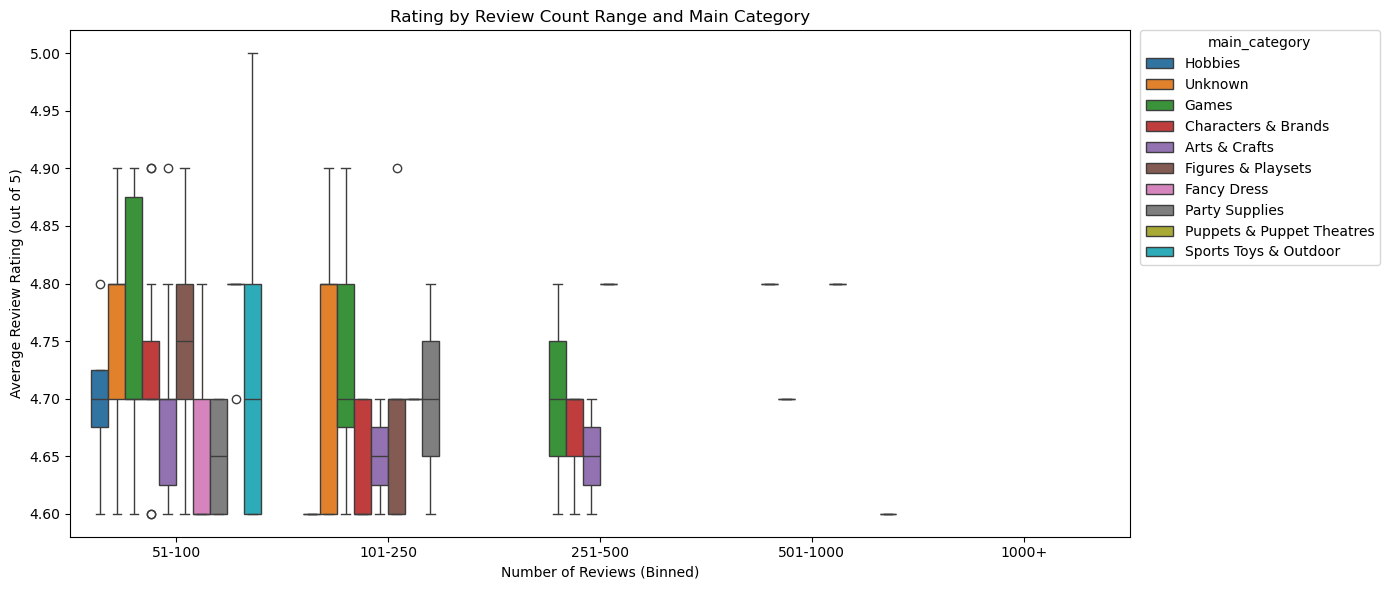

In [ ]:
# I tried using scatterplot, the points were too clustered together. Due to the large main category list, the points were overlapping each other, thus visualisation was bad.
# I have also tried using jitter to spread out the points, but it still did not look good.
# Then I tried using the violin plot, but it also did not look good because the distribution was not very clear.
# Finally, I tried boxplot and it looks good, because the distribution is clear.

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_top_filtered,
    x="review_bins",
    y="average_review_rating_out_of_5",
    hue="main_category",
    dodge=True, # This code ensures the review bin gets its own separate box, side by side, not overlapping each other.
    width=0.8)


plt.legend(
    title="main_category",
    bbox_to_anchor=(1.01, 1),  # Place legend outside the axes
    loc='upper left',
    borderaxespad=0) # Space between the legend and the graph


plt.title("Rating by Review Count Range and Main Category")
plt.xlabel("Number of Reviews (Binned)")
plt.ylabel("Average Review Rating (out of 5)")
plt.tight_layout()  # Prevent label/legend cutoff
plt.show()


### Feature Engineering

In [162]:
# Machine learning models primarily work with numerical data, hence the categorical data needs to be converted to numerical data.
# I decided to use label encoding because it is simple and effective for a large number of categories.
# Each unique category in the main_category column is encoded into numerical values to prepare for machine learning.

le = LabelEncoder()
cleaned_df['main_category_encoded'] = le.fit_transform(cleaned_df['main_category'])
#.fit_transform() allocates a unique integer to each category name in the 'main_category' column.

In [163]:
# I want to see the mapping between the original category names and their corresponding encoded values.

cleaned_df[['main_category', 'main_category_encoded']].drop_duplicates().sort_values('main_category_encoded')
# .drop_duplicates() removes duplicate rows, so that each category name only show once in the table.

,main_category,main_category_encoded
342,Arts & Crafts,0
2414,Baby & Toddler Toys,1
290,Bags,2
1269,Bedding & Linens,3
1721,Camping & Hiking,4
106,Characters & Brands,5
4381,Cooking & Dining,6
796,Die-Cast & Toy Vehicles,7
6023,Dogs,8
2437,Dolls & Accessories,9


### Machine Learning

In [ ]:
# I tried using decision tree to predic products that would recieve high average review rating, but the model didn't provide quick and simple visualisation.
# So now I will try clustering using K-Means to organise data with similar performance. 
# However, the K-Mean model will not provide predictions, as it is an unsupervised model.

# Group the main_category by aggregating the mean of number_of_reviews and average_review_rating_out_of_5.
category_summary = cleaned_df.groupby('main_category').agg({
    'number_of_reviews': 'mean',
    'average_review_rating_out_of_5': 'mean'}).reset_index()

In [165]:
# Prepare the data for clustering.
X = category_summary[['number_of_reviews', 'average_review_rating_out_of_5']]

kmeans = KMeans(n_clusters=3, random_state=42)
category_summary['cluster'] = kmeans.fit_predict(X)

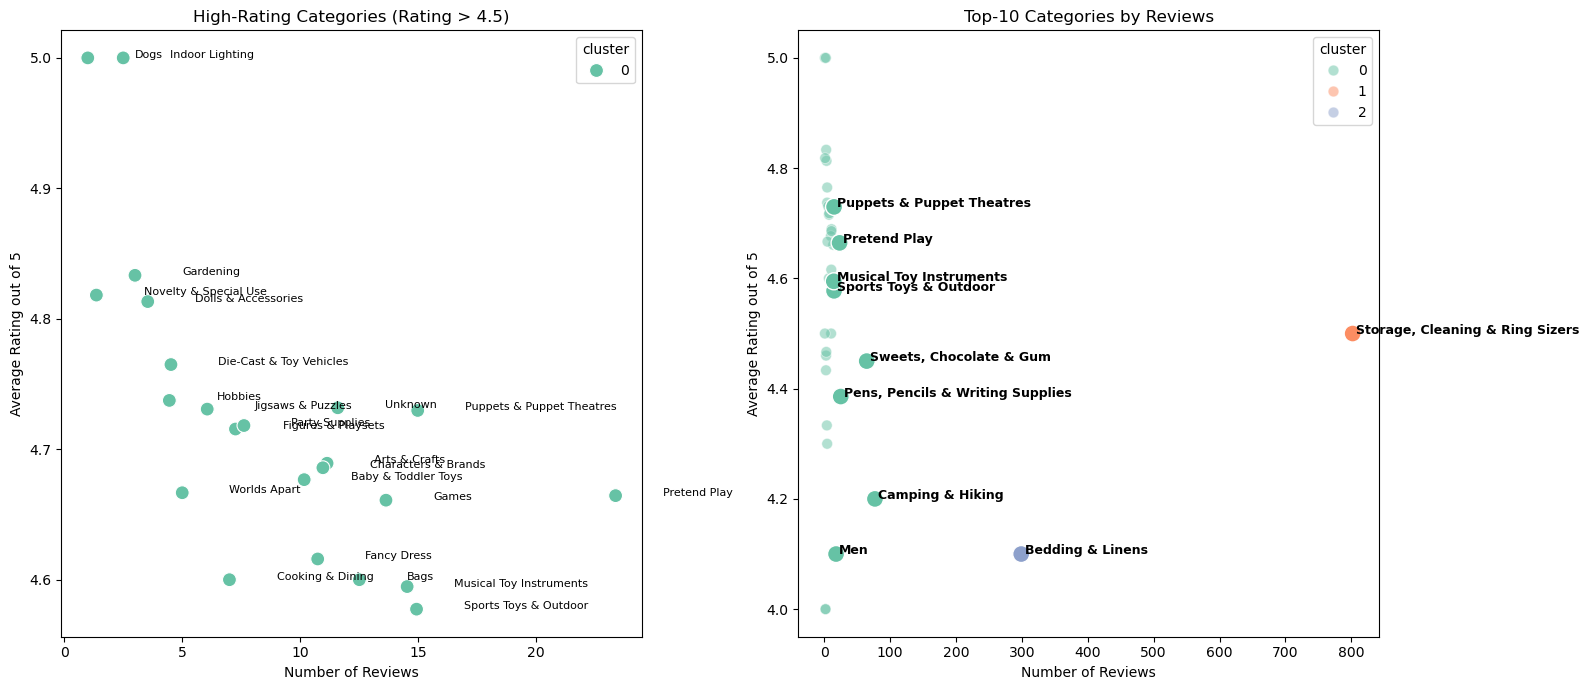

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Filter the review rating to > 4.5.
filtered = category_summary[category_summary['average_review_rating_out_of_5'] > 4.5]

sns.scatterplot(
    x='number_of_reviews',
    y='average_review_rating_out_of_5',
    hue='cluster',
    data=filtered,
    palette='Set2', s=100, ax=axes[0])

axes[0].set_title("High-Rating Categories (Rating > 4.5)")
axes[0].set_xlabel("Number of Reviews")
axes[0].set_ylabel("Average Rating out of 5")

# Labelling the categories
for i, row in filtered.iterrows():
    axes[0].text(row['number_of_reviews']+2, row['average_review_rating_out_of_5'],
                 row['main_category'], fontsize=8)

# Present the top 10 only.
top = category_summary.nlargest(10, 'number_of_reviews')

sns.scatterplot(
    x='number_of_reviews',
    y='average_review_rating_out_of_5',
    hue='cluster',
    data=category_summary,
    palette='Set2', s=60, alpha=0.5, ax=axes[1]  # faded background
)
sns.scatterplot(
    x='number_of_reviews',
    y='average_review_rating_out_of_5',
    hue='cluster',
    data=top,
    palette='Set2', s=150, ax=axes[1], legend=False  # highlight top
)
axes[1].set_title("Top-10 Categories by Reviews")
axes[1].set_xlabel("Number of Reviews")
axes[1].set_ylabel("Average Rating out of 5")

# Only label the top 10 categories, not the others.
for i, row in top.iterrows():
    axes[1].text(row['number_of_reviews']+5, row['average_review_rating_out_of_5'],
                 row['main_category'], fontsize=9, weight='bold', color='black')

plt.tight_layout()
plt.show()

In [ ]:
# Help understand what fall under cluster 0.
# Categories that full under the same cluster means they have similar number of reviews and average ratings.

cluster_0_categories = category_summary[category_summary['cluster'] == 0]['main_category'].tolist()

for category in cluster_0_categories:
    print("-", category)

- Arts & Crafts
- Baby & Toddler Toys
- Bags
- Camping & Hiking
- Characters & Brands
- Cooking & Dining
- Die-Cast & Toy Vehicles
- Dogs
- Dolls & Accessories
- Educational Toys
- Electronic Toys
- Fancy Dress
- Figures & Playsets
- Games
- Gardening
- Handbags & Shoulder Bags
- Hobbies
- Home Accessories
- Indoor Lighting
- Jigsaws & Puzzles
- Medication & Remedies
- Men
- Musical Toy Instruments
- Novelty & Special Use
- Office Supplies
- Party Supplies
- Pens, Pencils & Writing Supplies
- Pretend Play
- Puppets & Puppet Theatres
- Sex & Sensuality
- Sports Toys & Outdoor
- Supporters' Gear
- Sweets, Chocolate & Gum
- Unknown
- Women
- Worlds Apart


## Research Question 2
Q: Within the main category 'puppets & puppet theatres', which sub-category will sell best based on their current reviews and ratings?

A: Finger Puppets

### Plotting

In [168]:
# I will draw a bargraph grouping sub_category, average_rating_out_of_5 and number_of_reviews to see which stands out.

subcat_summary = (
    cleaned_df.groupby('sub_category')
    .agg(avg_rating=('average_review_rating_out_of_5', 'mean'),
         avg_reviews=('number_of_reviews', 'mean'))
    .reset_index())

In [169]:
subcat_summary = subcat_summary.sort_values('avg_reviews', ascending=False).head(15) 

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_99583/124763633.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(subcat_summary['sub_category'], rotation=45, ha='right') # Instruction for the x-axis label.


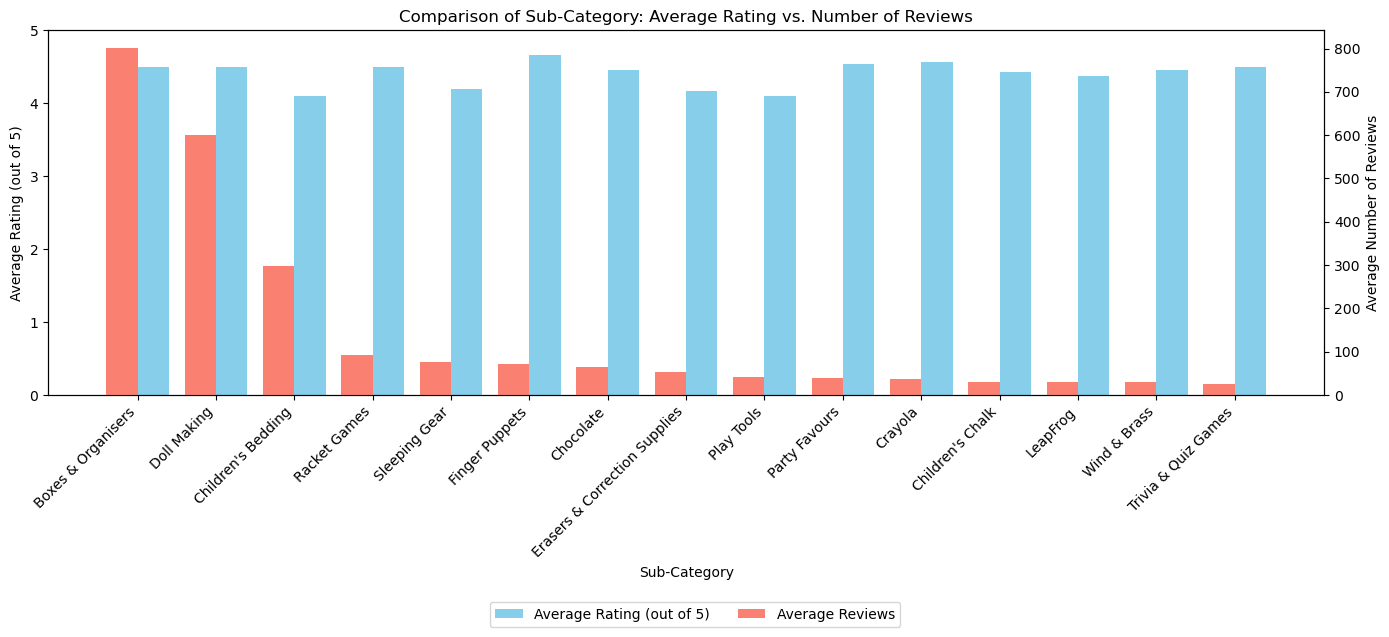

In [170]:
fig, ax1 = plt.subplots(figsize=(14,6))


# Instruction for the left y-axis
ax1.bar(subcat_summary['sub_category'], subcat_summary['avg_rating'], 
        width=0.4, align='edge', label='Average Rating (out of 5)', color='skyblue')
ax1.set_ylabel("Average Rating (out of 5)")
ax1.set_ylim(0, 5)
# ax1 is the one on the right, representing average rating out of 5.
# ax1.set_ylim is to set the scale limit from o to 5.

# Instruction for the right y-axis
ax2 = ax1.twinx()
ax2.bar(subcat_summary['sub_category'], subcat_summary['avg_reviews'], 
        width=-0.4, align='edge', label='Average Reviews', color='salmon')
ax2.set_ylabel("Average Number of Reviews")

ax1.set_xticklabels(subcat_summary['sub_category'], rotation=45, ha='right') # Instruction for the x-axis label.
ax1.set_xlabel("Sub-Category")
ax1.set_title("Comparison of Sub-Category: Average Rating vs. Number of Reviews")


# Add legends
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.00), ncol=2)

plt.tight_layout()
plt.show()


### Feature Engineering

In [171]:
# Due to the data working with is categorical, encoding the categorical data to numerical data is neccessary.
# Same approaches are applied as in Research Q1.

le = LabelEncoder()
cleaned_df['sub_category_encoded'] = le.fit_transform(cleaned_df['sub_category'])

In [172]:
cleaned_df[['sub_category', 'sub_category_encoded']].drop_duplicates().sort_values('sub_category_encoded')

,sub_category,sub_category_encoded
4759,3-D Puzzles,0
1174,Accessories,1
1015,Action Man,2
4514,Activity Centres,3
4447,Alternative Medicine,4
...,...,...
2729,Upstarts,131
6063,VTech,132
7071,WWE,133
6202,Wind & Brass,134


In [ ]:
# The number of reviews can have a very big value, yet the maximum in rating only goes up to 5. 
# Putting them together may confuses SVM during training, where one feature may dominate the other. 
# Hence, standardisation is neccessary.

sub_data = cleaned_df[cleaned_df['main_category'] == 'Puppets & Puppet Theatres'].copy()

X = sub_data[['number_of_reviews', 'average_review_rating_out_of_5']].values 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Before scaling (first 5 rows):")
print(X[:5])
print("\nAfter scaling (first 5 rows):")
print(X_scaled[:5]) 

X = sub_data[['number_of_reviews', 'average_review_rating_out_of_5']].values  

Before scaling (first 5 rows):
[[517 4.2]
 [3 5.0]
 [4 4.8]
 [1 5.0]
 [1 5.0]]

After scaling (first 5 rows):
[[ 9.0409456  -1.62571269]
 [-0.21563839  0.82939868]
 [-0.19762947  0.21562084]
 [-0.25165622  0.82939868]
 [-0.25165622  0.82939868]]


In [174]:
print("Means after scaling:", np.mean(X_scaled, axis=0))
print("Standard deviations after scaling:", np.std(X_scaled, axis=0))

# Now, the standard deviations are standardised to 1.
# Now, both features can contribute equally to the ML model. No feature will be dominating over another. 

Means after scaling: [-8.25444628e-18 -8.12237514e-16]
Standard deviations after scaling: [1. 1.]


### Machine Learning

In [ ]:
# Firstly, I wanted to double check all the sub categories tthat fall under the main category 'puppet & puppet theatres'.

subcategories_list = cleaned_df.loc[
    cleaned_df['main_category'].str.strip().str.lower() == 'puppets & puppet theatres',
    'sub_category'
].unique().tolist()

print(subcategories_list)

['Finger Puppets', 'Hand Puppets', 'Accessories']


In [176]:
# I want to use a supervised learning model on the labelled data to help make prediction on which sub category will sell best.
# The SVM model will be used to separate the sub categories based on the combination outcomes of number_of_reviews and average_review_rating_out_of_5.

puppet_df = cleaned_df[cleaned_df['main_category'] == 'Puppets & Puppet Theatres']

subcat_cleaned_df = puppet_df.groupby('sub_category').agg({
    'number_of_reviews': 'mean',
    'average_review_rating_out_of_5': 'mean'
}).reset_index()

In [177]:
X = subcat_cleaned_df[['number_of_reviews', 'average_review_rating_out_of_5']].values  

# Define "best performing" as high rating AND high reviews
y = ((subcat_cleaned_df['average_review_rating_out_of_5'] >= 4.2) & 
     (subcat_cleaned_df['number_of_reviews'] >= 50)).astype(int)

In [178]:
# I want to find the best performing sub category based on a calculated score.

subcat_cleaned_df['score'] = subcat_cleaned_df['average_review_rating_out_of_5'] * subcat_cleaned_df['number_of_reviews']

print(subcat_cleaned_df[['sub_category', 'number_of_reviews', 'average_review_rating_out_of_5', 'score']])

     sub_category  number_of_reviews  average_review_rating_out_of_5  \
0     Accessories                1.0                        4.000000   
1  Finger Puppets          72.074074                        4.659259   
2    Hand Puppets           8.634855                        4.740664   

        score  
0         4.0  
1  335.811797  
2   40.934944  


In [179]:
# This will give me a best scored sub category.
best_idx = subcat_cleaned_df['score'].idxmax()

# Create y labels: 1 for the best, 0 for otherwise.
y = (subcat_cleaned_df.index == best_idx).astype(int)

print("Best sub-category:", subcat_cleaned_df.loc[best_idx, 'sub_category'])

Best sub-category: Finger Puppets


In [180]:
# Create x labels
X = subcat_cleaned_df[['number_of_reviews', 'average_review_rating_out_of_5']].values  

# Standardised X
X_scaled = scaler.fit_transform(X)

In [181]:
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_scaled, y)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


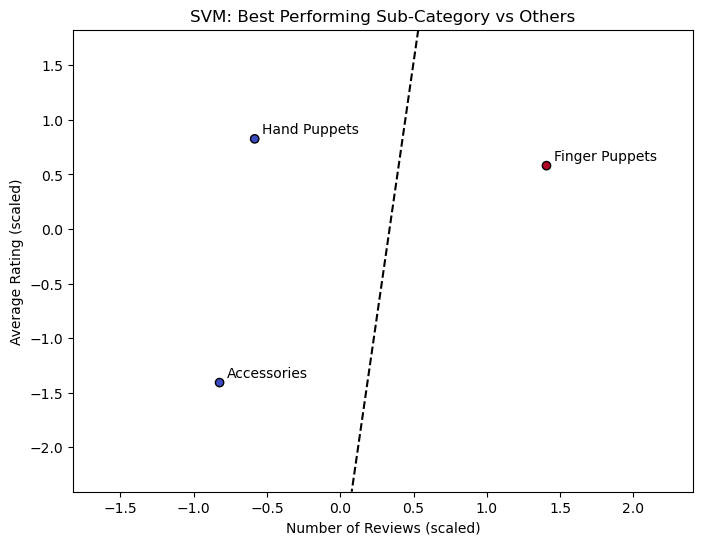

In [182]:
plt.figure(figsize=(8,6))

plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='coolwarm', edgecolors='k')

# Annotate sub-category names on the scatter.
for i, txt in enumerate(subcat_cleaned_df['sub_category']):
    plt.annotate(txt, (X_scaled[i,0]+0.05, X_scaled[i,1]+0.05))

# Decision boundary
xx, yy = np.meshgrid(
    np.linspace(X_scaled[:,0].min()-1, X_scaled[:,0].max()+1, 200),
    np.linspace(X_scaled[:,1].min()-1, X_scaled[:,1].max()+1, 200))

Z = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['--'])

plt.xlabel("Number of Reviews (scaled)")
plt.ylabel("Average Rating (scaled)")
plt.title("SVM: Best Performing Sub-Category vs Others")
plt.show()

## Research Qustion 3
Q: What is the minimum unit quantity I should prepare to start a business based on avalable stock quantities?

A: Based on the ML model, most categories have a stock availability clustered below 10 units. When I calculated the 25th, 50th, and 75th percentiles to differentiate stock levels, the average stock unit between the 50th and 75th percentiles was 5. Therefore, the minimum quantity to start a business with should be 5 units.

### Plotting

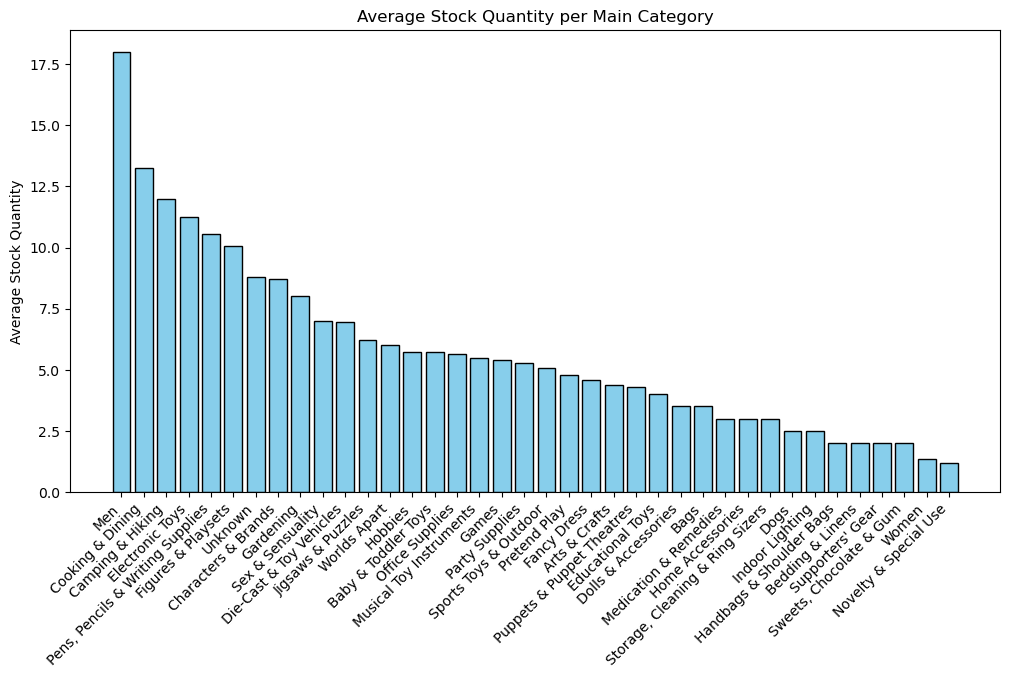

In [183]:
# Find the mean stock_quantity per main category by grouping these two features together.
stock_summary = cleaned_df.groupby('main_category')['stock_quantity'].mean().reset_index()

# Provide a sorted summary.
stock_summary = stock_summary.sort_values('stock_quantity', ascending=False)

# Create histogram.
plt.figure(figsize=(12,6))
plt.bar(stock_summary['main_category'], stock_summary['stock_quantity'], color='skyblue', edgecolor='black')

plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Stock Quantity")
plt.title("Average Stock Quantity per Main Category")

plt.show()

### Feature Engineering

In [ ]:
# I will scale the stock_quantity data using standardisation, because I want to create a linear regression training model later.
# Since linear regression training model assumes the data to be normally distributed, so standardisation is preferred over normalisation.

X = cleaned_df[['number_of_reviews', 'average_review_rating_out_of_5']].values
y = cleaned_df['stock_quantity'].values

In [185]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check first 5 rows before and after scaling
print("Before scaling (first 5 rows):")
print(X[:5])
print("\nAfter scaling (first 5 rows):")
print(X_scaled[:5])

Before scaling (first 5 rows):
[[15 4.9]
 [2 4.5]
 [17 3.9]
 [1 5.0]
 [3 4.7]]

After scaling (first 5 rows):
[[ 0.21205339  0.51787993]
 [-0.23751088 -0.55746619]
 [ 0.28121713 -2.17048538]
 [-0.27209275  0.78671646]
 [-0.20292902 -0.01979313]]


In [186]:
print("Means after scaling:", np.mean(X_scaled, axis=0))
print("Standard deviations after scaling:", np.std(X_scaled, axis=0))

# It is successfully standardised.

Means after scaling: [4.69756792e-17 1.29538994e-16]
Standard deviations after scaling: [1. 1.]


### Machine Learning

In [187]:
# Splits partial data into training (majority) and partial for training.
# This part can help to evaluate the model on unseen data.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Create and train the model.
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Perform prediction on stock_quantity based on the test data.
y_pred = lin_reg.predict(X_test)

# Evaluate on the prediction on the test data.
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 57.3566178045773
R² Score: 0.038287207447285865


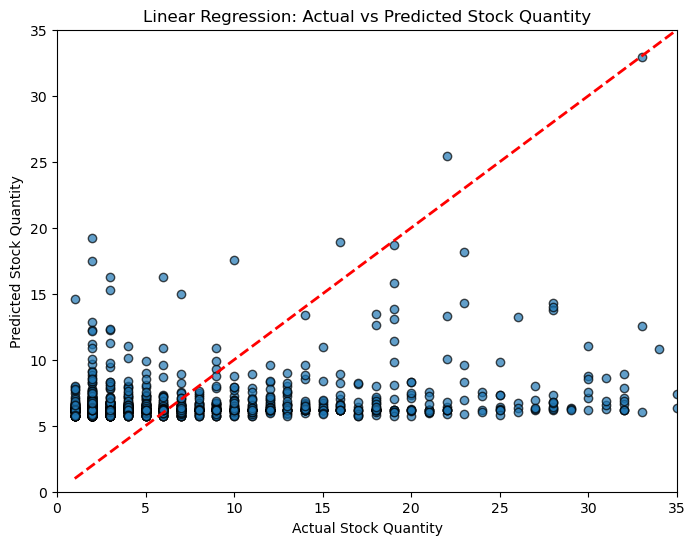

In [ ]:
# Scatter plot of actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')

# Add a line y=x for perfect predictions
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)

# I initially created the linear regression model based on actual stock quantity, and the range went up to 70.
# However, stocks beyond 35 are quite spread out.
# So, I decided to focus on the 0–35 range, which is the most clustered stock value range.
plt.xlim(0, 35)
plt.ylim(0, 35)

plt.xlabel("Actual Stock Quantity")
plt.ylabel("Predicted Stock Quantity")
plt.title("Linear Regression: Actual vs Predicted Stock Quantity")
plt.show()


In [189]:
p25 = np.percentile(cleaned_df['stock_quantity'], 25)  # 25th percentile
p50 = np.percentile(cleaned_df['stock_quantity'], 50)  # 50th percentile (median)
p75 = np.percentile(cleaned_df['stock_quantity'], 75)  # 75th percentile

print("25th percentile (lower bound):", p25)
print("50th percentile (median):", p50)
print("75th percentile (upper bound):", p75)

25th percentile (lower bound): 2.0
50th percentile (median): 3.0
75th percentile (upper bound): 7.0


## Research Question 4

Q: Which seller offers the cheapest price for the same product?

I originally wanted to create a KNN model using seller_name_encoded, stock_condition_encoded, and cleaned_price. However, these variables are categorical rather than continuous. Due to the data type requirement not being met, the KNN model did not produce clear clusters or visible boundaries. I also tried using a decision tree model, but it did not work well either. Although I am not completely sure which ML model would be the most suitable for this question, I found that the bar plot and bar graph were sufficient to answer the question. The bar plot clearly showed the minimum, maximum, and middle prices for the same products. In addition, the bar graph further enhanced the analysis by helped identify which seller offered the lowest price. There, no ML approach was used in this question.

### Plotting

In [190]:
# Count the unique price by product.
price_variation = cleaned_df.groupby('product_name')['cleaned_price'].nunique().reset_index()

# I only want to show same products with more than 1 unique price 
products_with_varied_price = price_variation[price_variation['cleaned_price'] > 1]['product_name']

# Price compare the value/s using the .isin function.
price_comp_df = cleaned_df[cleaned_df['product_name'].isin(products_with_varied_price)]

print(price_comp_df.head())



                              uniq_id  \
71   1e9876e6f7e98a6bb869341b4b56efd5   
411  b585918cbbf998a288bbb259313f0296   
471  b5b9d9641ddd0c677c5ddaa719207f63   
632  4d8bead8e9ce03e48f5c682f75b371b0   
670  a39c1fb94ba6029ba492ee9a5dc1c97f   

                                product_name  number_of_reviews  \
71             Power Trains Auto Loader City                  0   
411                          Polyhedral Dice                  1   
471                          Polyhedral Dice                  1   
632  Schleich Farm Christmas Advent Calendar                  8   
670                   Barbie Advent Calendar                  4   

     cleaned_price  stock_quantity stock_condition  \
71           76.99               2             new   
411          11.93               4             new   
471           9.74               2             new   
632          31.00               7             new   
670          13.21              14             new   

     average_review_ratin

In [191]:
# Find minimum price by grouping product name and seller name together.
product_price_df = price_comp_df.groupby(['product_name', 'seller_name'])['cleaned_price'].min().reset_index()

# Sort by product then price.
product_price_df = product_price_df.sort_values(by=['product_name', 'cleaned_price'])

print(product_price_df.head(10))

                                        product_name          seller_name  \
0                             Barbie Advent Calendar              Toystar   
1  Happy 6th Birthday Giant Party Wall Banner 3 B...                  nan   
2  LEGO Collectable Minifigures: Crash Test Dummy...                  nan   
3                     Melissa & Doug Princess Puppet                  Buy   
4      Melissa & Doug Stacking Construction Vehicles                  nan   
5  Meng "Model 1:35 Toyota Hilux Pick Up Truck w/...         Amazon.co.uk   
6  Optimus Prime DMK 01 Transformers Movie Dual M...  AmazingVillageJapan   
7  Optimus Prime DMK 01 Transformers Movie Dual M...                  nan   
8                     Orchard Toys Farmyard Dominoes                Atrad   
9                     Orchard Toys Farmyard Dominoes    Souvenirs & Gifts   

   cleaned_price  
0          13.21  
1           1.55  
2           9.99  
3          16.99  
4          10.99  
5          22.99  
6          88.96  


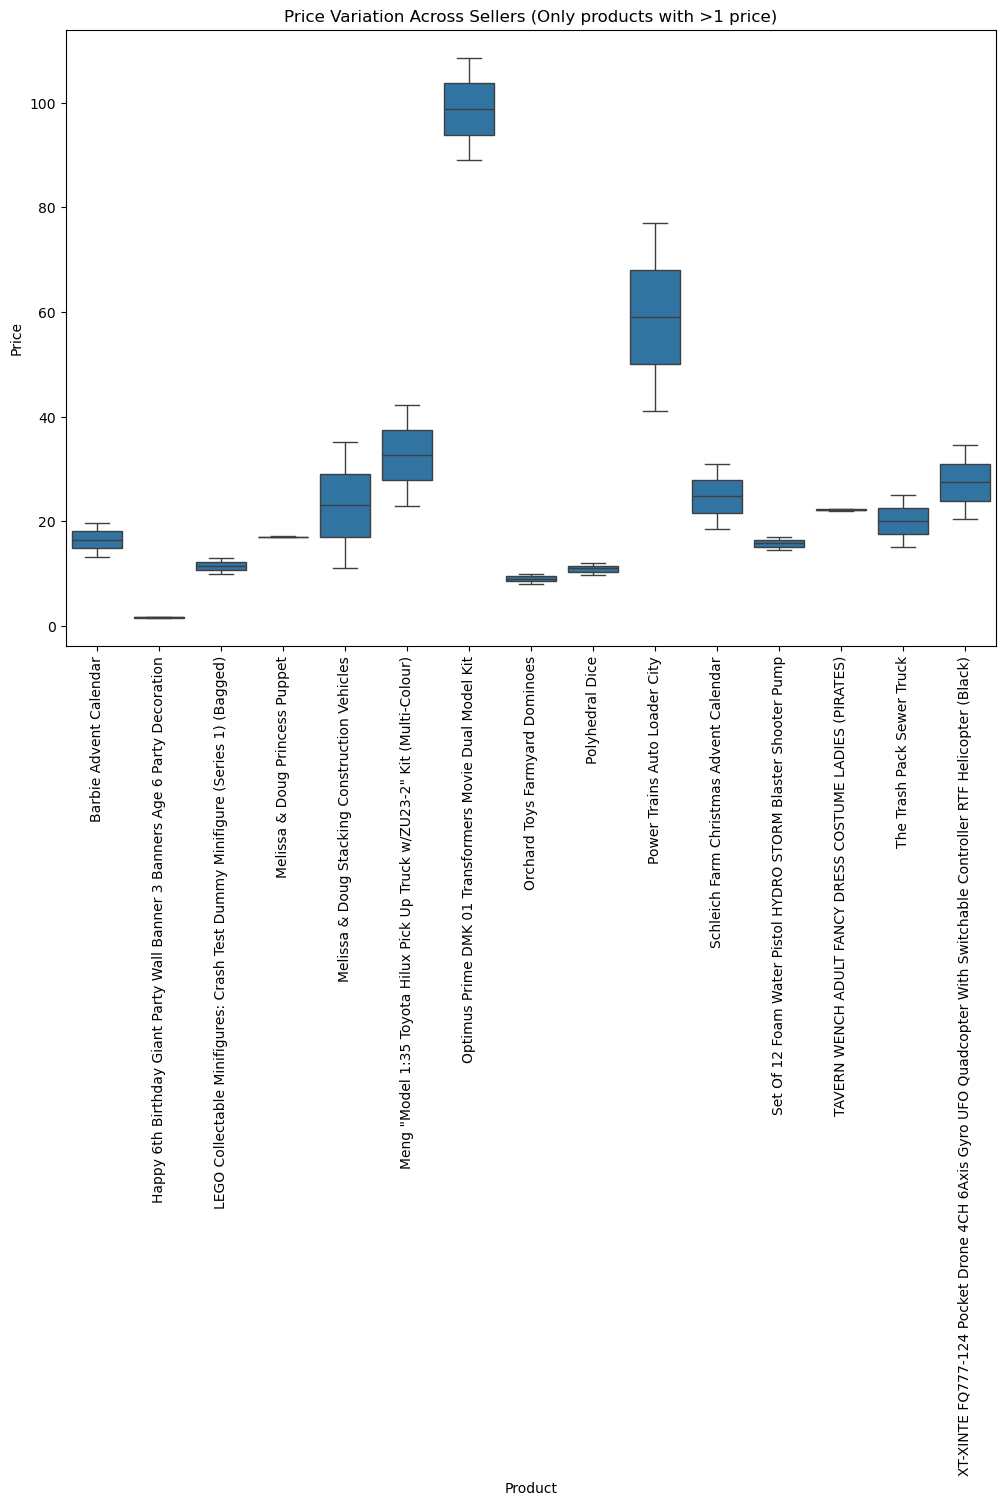

In [192]:
# I want the product names present in alphabetical order on the x-axis.
order_box = sorted(price_comp_df['product_name'].unique())

plt.figure(figsize=(12,8))
sns.boxplot(x='product_name', y='cleaned_price', data=price_comp_df, order=order_box)
plt.xticks(rotation=90)
plt.title("Price Variation Across Sellers (Only products with >1 price)")
plt.ylabel("Price")
plt.xlabel("Product")
plt.show()



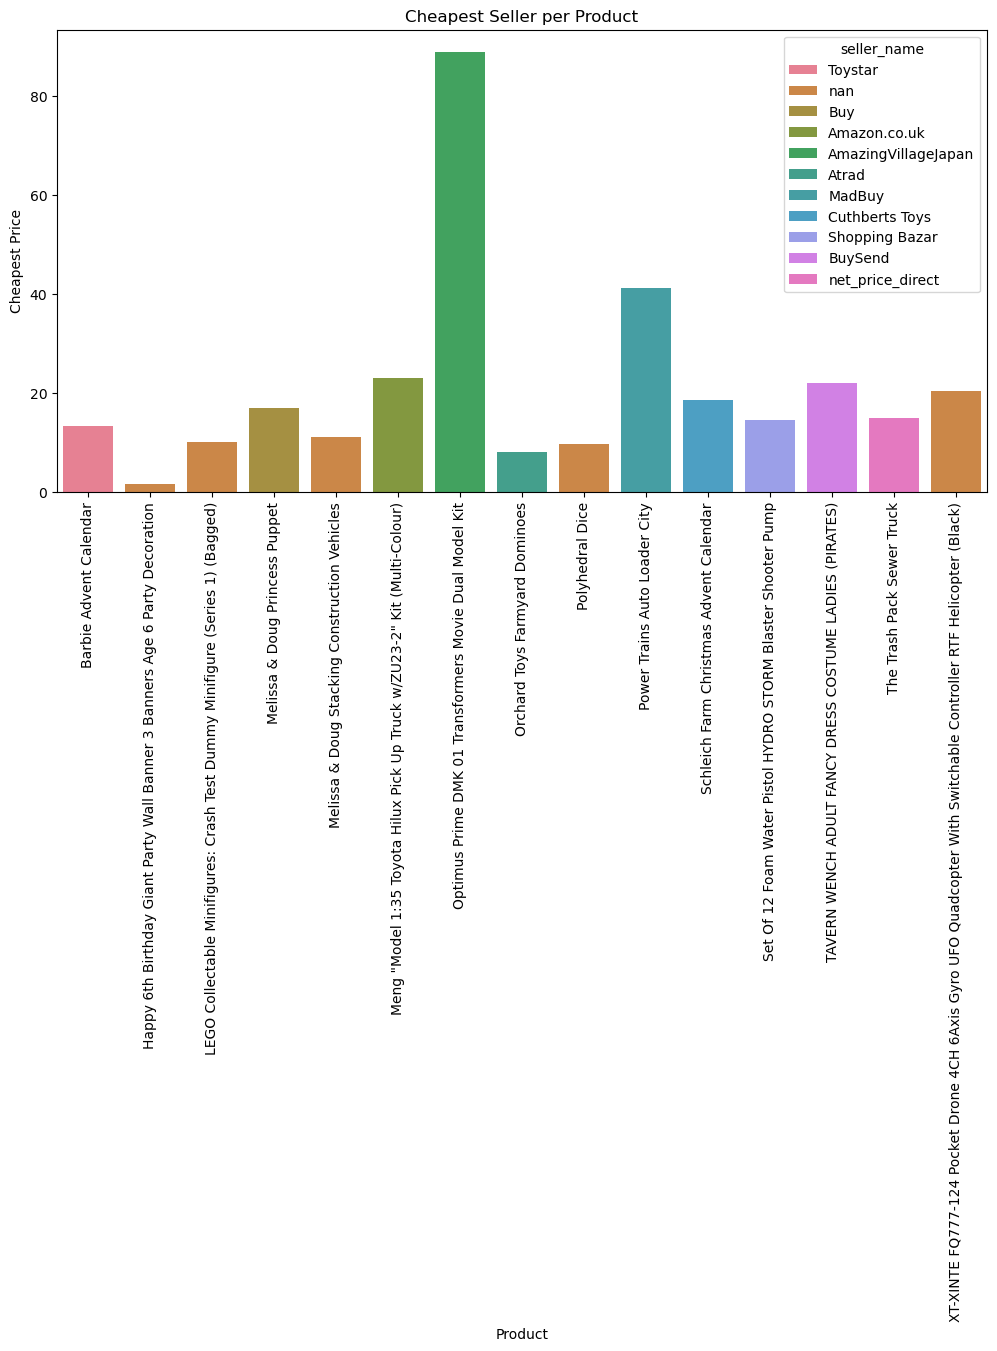

In [193]:
cheapest_sellers = product_price_df.groupby('product_name').first().reset_index()

# I want the product names present in alphabetical order on the x-axis.
order_bar = sorted(cheapest_sellers['product_name'].unique())

plt.figure(figsize=(12,6))
sns.barplot(x='product_name', y='cleaned_price', hue='seller_name', data=cheapest_sellers, order=order_bar)
plt.xticks(rotation=90)
plt.title("Cheapest Seller per Product")
plt.ylabel("Cheapest Price")
plt.xlabel("Product")
plt.show()


### Feature Engineering

In [194]:
# The seller names can be label encoded for ML training.

le = LabelEncoder()
cleaned_df['seller_name_encoded'] = le.fit_transform(cleaned_df['seller_name'])

In [195]:
# I Creating a KNN model requires more than 2 features, thus just the cleaned_price is not enough.
# I decided to add in stock_condition.
# All freatures required to be in numerical dataype, so I am encoding it to numerical category data for subsequent use. 
le_condition = LabelEncoder()
price_comp_df['stock_condition_encoded'] = le_condition.fit_transform(price_comp_df['stock_condition'])

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_99583/1320286769.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_comp_df['stock_condition_encoded'] = le_condition.fit_transform(price_comp_df['stock_condition'])


In [196]:
print(price_comp_df[['stock_condition', 'stock_condition_encoded']].head())

    stock_condition  stock_condition_encoded
71              new                        0
411             new                        0
471             new                        0
632             new                        0
670             new                        0


## Research Question 5

Q: Which sellers have received more consistent high ratings for their products?

A: The sellers who have consistently received high product ratings with the smallest standard deviation across 30, 50, and 70 products are Models4hobby, ALPHA GROUP MODELS, and Smaller World Future, respectively.

### Ploting

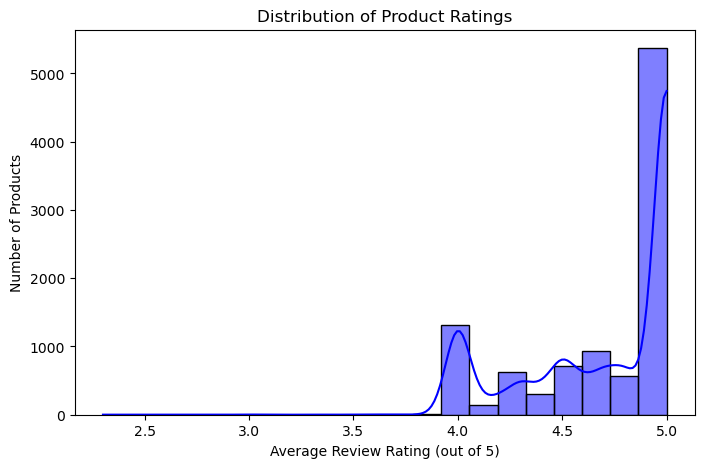

In [224]:
# I want to determine the majority score for product ratings

plt.figure(figsize=(8,5))  # set figure size
sns.histplot(cleaned_df['average_review_rating_out_of_5'], bins=20, kde=True, color='blue')

plt.xlabel("Average Review Rating (out of 5)")
plt.ylabel("Number of Products")
plt.title("Distribution of Product Ratings")

plt.show()

In [225]:
# Firstly, I want see the number of products each seller offers.
seller_counts_df = cleaned_df['seller_name'].value_counts().reset_index()
seller_counts_df.columns = ['seller_name', 'num_products']

print(seller_counts_df)

               seller_name  num_products
0                      nan          3075
1             Amazon.co.uk           659
2                      Buy           121
3                       k2            93
4     Smaller World Future            81
...                    ...           ...
2016         Joking Around             1
2017         Rapid Rooster             1
2018       Dream2RealityEU             1
2019              Ascrafts             1
2020      JIMMYS DROP SHOP             1

[2021 rows x 2 columns]


In [ ]:
# Then, I want to identify the top sellers whose products consistently receive high ratings. 
# It's not helpful to call out sellers who have great ratings but have sold only one or two products. 
# So, I want to identify sellers with the best and most consistently high ratings across a certain number of products.

# Group the features for statistical calculations.
seller_stats = (
    cleaned_df.groupby('seller_name')['average_review_rating_out_of_5']
    .agg(['mean', 'std', 'count'])
    .reset_index())

# Features contribute to stats analysis.
seller_stats.columns = ['seller_name', 'avg_rating', 'rating_std', 'num_products']

# Filter sellers who have consistent good rating across certain number of products.
seller_stats_filtered = seller_stats[seller_stats['num_products'] > 70]

# Output sort by descending average rating and ascending low std deviation.
consistent_high_sellers = seller_stats_filtered.sort_values(
    by=['avg_rating', 'rating_std'], ascending=[False, True]
)

# Show top sellers with consistent high ratings. 
print(consistent_high_sellers.head(20))

               seller_name  avg_rating  rating_std  num_products
1333  Smaller World Future    4.812346    0.355100            81
1182       Puppets By post    4.746753    0.270275            77
1901                   nan    4.717691    0.371311          3075
227                    Buy    4.690083    0.380877           121
1859                    k2    4.678495    0.405358            93
84            Amazon.co.uk    4.670561    0.362843           659


## Research Question 6

Q: Do sales fluctuate throughout the year? Which months have made the most sale, and what's the prediction for that?

A: Yes, sales fluctuate throughout the year. January and December usually have the highest sales, and the trend is predicted to stay the same in 2017.

### Plotting

In [251]:
# I want to check the time range of this dataset.

start_year = cleaned_df['purchase_year'].min()
end_year = cleaned_df['purchase_year'].max()

print(f"The time range is from {start_year} to {end_year}.")

The time range is from 2001 to 2016.


In [ ]:
# I will create a heatmap to demonstrate top sale months ranging from 2001 to 2016.
# I think heatmap suits this scenario, because it can clearly show off intensity.

# First, create a new column to sum up the sales.
cleaned_df['sales'] = cleaned_df['cleaned_price'] * cleaned_df['stock_quantity']

# Group relevant features together to represent sales of each month across the years.
year_month_sales = cleaned_df.groupby(['purchase_year', 'purchase_month'])['sales'].sum().reset_index()

# Create pivot table
sales_pivot = year_month_sales.pivot(index='purchase_year',
                                     columns='purchase_month',
                                     values='sales')

# Ensure month order
sales_pivot = sales_pivot.reindex(columns=range(1,13))

# It was discovered that there are some NaN (most likely no sale?), so fill in with 0 and change to numerical data. 
sales_pivot = sales_pivot.astype(float).fillna(0)

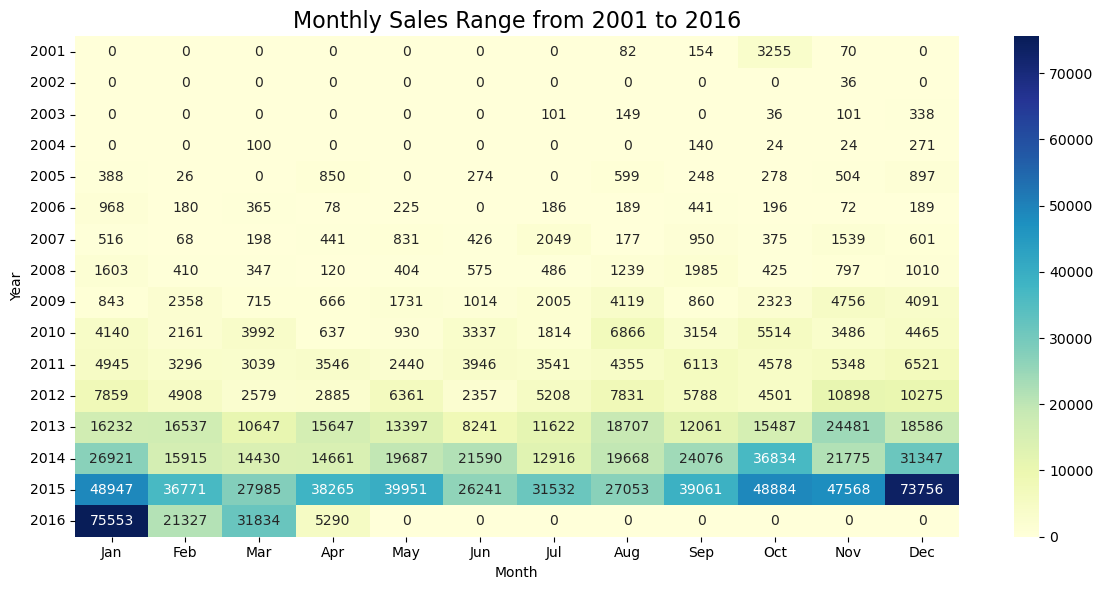

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(sales_pivot, cmap="YlGnBu", annot=True, fmt=".0f")

plt.title("Monthly Sales Range from 2001 to 2016", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Year")
plt.xticks(ticks=np.arange(0.5, 12.5),
           labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
           rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Feature Engineering

In [ ]:
# I will use cyclical encoding to convert the months, even though they are already in month number.
# The reason to do this is to prepare for ML, because without cyclical encoding conversion, the months would recognised as far apart from each other during ML training.
# Upon encoding, the distance between the month will be learned (i.e., Jan is next to Dec).
# This approach will use sin and cos to map the month.

cleaned_df['month_sin'] = np.sin(2 * np.pi * cleaned_df['purchase_month'] / 12)
cleaned_df['month_cos'] = np.cos(2 * np.pi * cleaned_df['purchase_month'] / 12)

print(cleaned_df[['purchase_month', 'month_sin', 'month_cos']].head(15))


    purchase_month  month_sin  month_cos
0                4   0.866025       -0.5
1               12       -0.0        1.0
2                5        0.5  -0.866025
3                7       -0.5  -0.866025
4                4   0.866025       -0.5
5               12       -0.0        1.0
6               10  -0.866025        0.5
7               12       -0.0        1.0
8               12       -0.0        1.0
9                1        0.5   0.866025
10               1        0.5   0.866025
11              11       -0.5   0.866025
12              10  -0.866025        0.5
13              10  -0.866025        0.5
14               2   0.866025        0.5


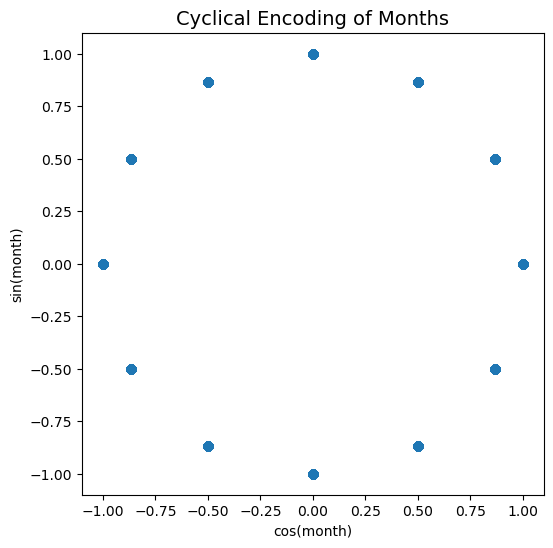

In [255]:
# The cyclical encoding brings Jan and Dec next to each other, creating a cycle.

plt.figure(figsize=(6,6))
plt.scatter(cleaned_df['month_cos'], cleaned_df['month_sin'], alpha=0.3)
plt.title("Cyclical Encoding of Months", fontsize=14)
plt.xlabel("cos(month)")
plt.ylabel("sin(month)")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Machine Learning

In [ ]:
# I attempted to use a Random Forest Regressor to provide an answer to this question.
# However, it did not work out well because the model gave almost a flat line for sales prediction.
# I later found out that Random Forest does not perform well with sequential data, unless highly skilled, which I am not. 
# Because of this, I switched to a model that works better with time series data, which is SARIMA. 
# In class, we talked about ARIMA, but SARIMA is basically an advanced version that can do a bit more.
# For example, SARIMA can model both time series trends and seasonality (regular repeating patterns).

# Prepare data for testing and training.
monthly_sales = cleaned_df.groupby(['purchase_year', 'purchase_month'])['sales'].sum().reset_index()

monthly_sales['year_month'] = pd.to_datetime(monthly_sales['purchase_year'].astype(str) + '-' + 
                                             monthly_sales['purchase_month'].astype(str) + '-01')
monthly_sales.set_index('year_month', inplace=True)

In [257]:
# Focus on 2012 onward, because this is when monthly sales increased substantially.
monthly_sales = monthly_sales[monthly_sales.index >= '2012-01-01']
sales_ts = monthly_sales['sales']

In [258]:
# Train and test the prepared data.
train_size = int(len(sales_ts) * 0.8) # Conventionally, 80% of the data are used for training and 20% are used for testing.
train_ts = sales_ts.iloc[:train_size]
test_ts = sales_ts.iloc[train_size:]

In [259]:
# Build Sarima model.
model = SARIMAX(train_ts, order=(1,1,1), seasonal_order=(1,1,1,12))
# order=(1,1,1) means capture monthly repeating pattern (i.e., last month’s sales)
# seasonal_order=(1,1,1,12) means captures yearly repeating patterns (i.e., last year's same month sale)
sarima_fit = model.fit(disp=False)


/opt/anaconda3/envs/COMP647_env_py312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/COMP647_env_py312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/COMP647_env_py312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/COMP647_env_py312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations 

In [260]:
# Prediction
# This model requires to use integer-based indexing, otherwise resulting in KeyError.
y_pred = sarima_fit.predict(start=len(train_ts), end=len(train_ts)+len(test_ts)-1, dynamic=False)
y_pred.index = test_ts.index  # align with actual test dates

print("Mean Squared Error:", mean_squared_error(test_ts, y_pred))

Mean Squared Error: 338661405.7001274


In [261]:
# Forcast coming year.
forecast_steps = 12
forecast_2017 = sarima_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start='2017-01-01', periods=forecast_steps, freq='MS')
forecast_2017 = pd.Series(forecast_2017.predicted_mean.values, index=forecast_index)


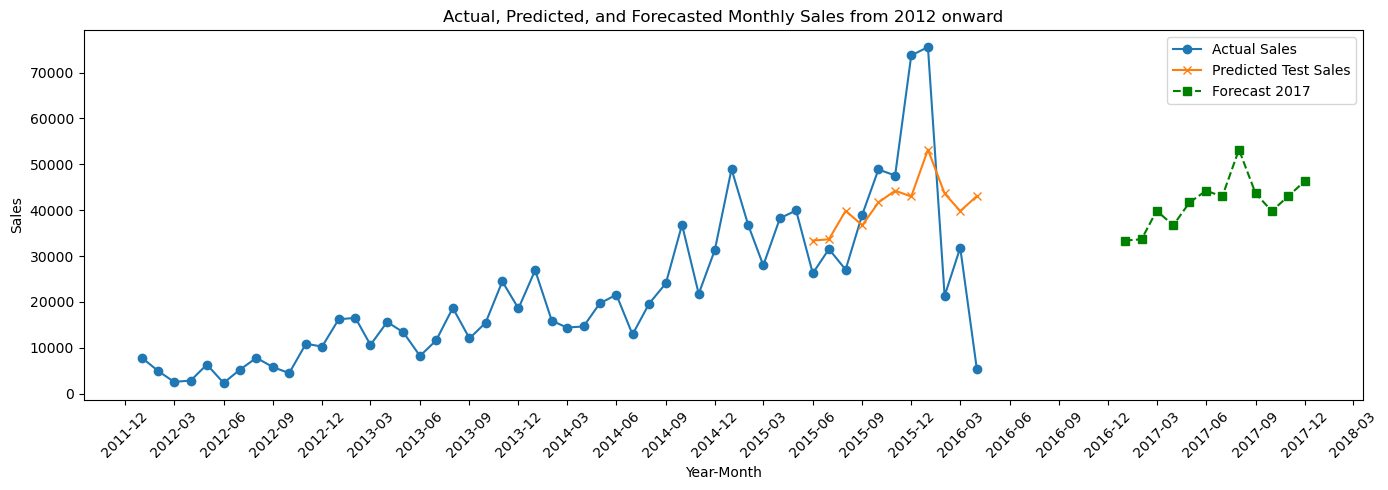

In [262]:
# Plot the Sarima model.
plt.figure(figsize=(14,5))

# Plot actual sales line.
plt.plot(sales_ts.index, sales_ts.values, label="Actual Sales", marker='o')

# Plot predict sales line.
plt.plot(y_pred.index, y_pred.values, label="Predicted Test Sales", marker='x')

# Plot forcast line.
plt.plot(forecast_2017.index, forecast_2017.values, label="Forecast 2017", marker='s', linestyle='--', color='green')

# Demanding x-axis to show every 3 month of the year.
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title("Actual, Predicted, and Forecasted Monthly Sales from 2012 onward")
plt.xlabel("Year-Month")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Reseaerch Question 7

Q: Which year recorded the highest purchase activity and which main product categories did most purchases come?

### Plotting

In [ ]:
# Firstly, I want to visualise sales count by year numerically.
sales_by_year = cleaned_df.groupby("purchase_year")["uniq_id"].count().reset_index()
sales_by_year.rename(columns={"uniq_id": "total_sales"}, inplace=True)
print(sales_by_year)

    purchase_year  total_sales
0            2001            7
1            2002            1
2            2003           10
3            2004            8
4            2005           19
5            2006           18
6            2007           49
7            2008           64
8            2009          160
9            2010          238
10           2011          397
11           2012          615
12           2013         1476
13           2014         2207
14           2015         3682
15           2016         1032


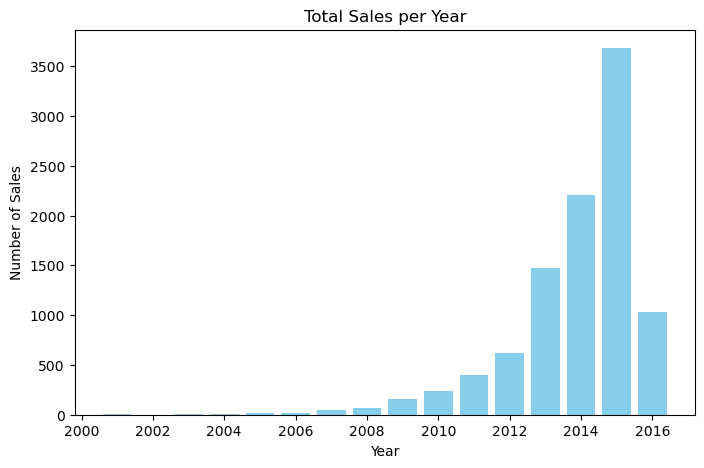

In [240]:
plt.figure(figsize=(8,5))
plt.bar(sales_by_year["purchase_year"], sales_by_year["total_sales"], color="skyblue")
plt.title("Total Sales per Year")
plt.xlabel("Year")
plt.ylabel("Number of Sales")
plt.show()

In [241]:
# Then, I want to visualise which main category contribute to the sales per year through a barplot.

sales_by_year_cat = cleaned_df.groupby(["purchase_year", "main_category"])["uniq_id"].count().reset_index()
sales_by_year_cat.rename(columns={"uniq_id": "total_sales"}, inplace=True)
print(sales_by_year_cat.head())

   purchase_year        main_category  total_sales
0           2001  Characters & Brands            7
1           2002  Characters & Brands            1
2           2003  Characters & Brands            4
3           2003                Games            3
4           2003              Hobbies            2


In [242]:
# I firstly let the graph to diaplay the entire timeline, but it was very crowded, so I decided to focus on 2010 onwards only.
sales_by_year_cat = sales_by_year_cat[sales_by_year_cat["purchase_year"] >= 2010]

# Same as above, it was too crowded to display all categories, so limit to top 10.
top_categories = sales_by_year_cat.groupby("main_category")["total_sales"].sum().nlargest(10).index

# Filter top categories
sales_by_year_cat_top10 = sales_by_year_cat[sales_by_year_cat["main_category"].isin(top_categories)]


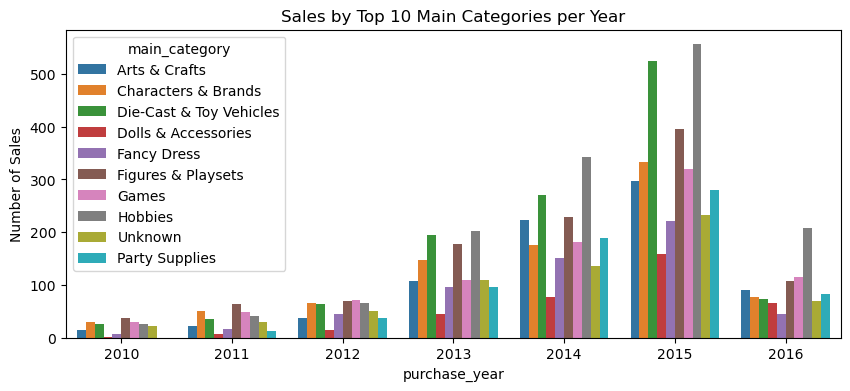

In [243]:
plt.figure(figsize=(10,4))
sns.barplot(x="purchase_year", y="total_sales", hue="main_category", data=sales_by_year_cat_top10)
plt.title("Sales by Top 10 Main Categories per Year")
plt.ylabel("Number of Sales")
plt.show()

## Research Question 8
Q: What are the main factors of the sold products that may be contributing to the variation in sales?

A: Eight features were analysed to address the question. Based on the PCA model, PC1 to PC4 contribute to 50% of the factors linked to the sales variations. These components include the number of reviews and stock quantity from PC1; price and recommended age from PC2; purchase month from PC3; and item weight from PC4.

### Machine Learning

In [244]:
# This is a question that requires data analysis, hence an unsupervised ML model is most suitable.
# I think a PCA model would be very suitable for this question, as it can help analyse the importance of each component to the question.

# ML can only work with numeric data, so the features I'm going to keep for model training are numeric type only.
features = [
    'cleaned_price', 
    'stock_quantity', 
    'number_of_reviews', 
    'average_review_rating_out_of_5', 
    'item_weight_in_kg', 
    'recommended_minimum_age_years', 
    'month_sin', 
    'month_cos']

X = cleaned_df[features]

In [245]:
# I will standardise the scale so that one will not dominant another.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [246]:
# Form the PCA model
pca = PCA(n_components=None)   
X_pca = pca.fit_transform(X_scaled)

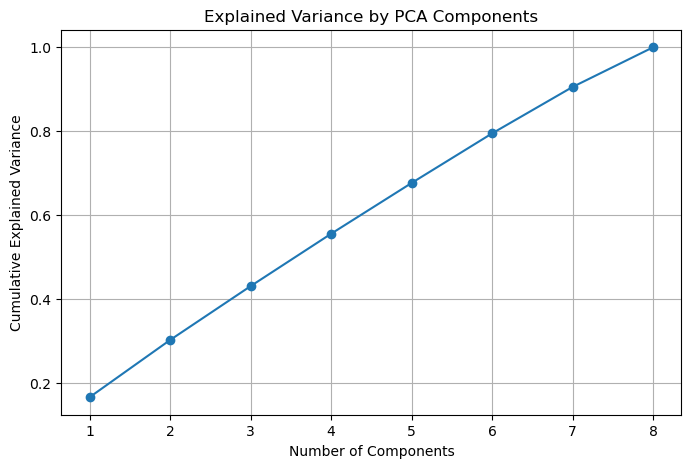

In [247]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

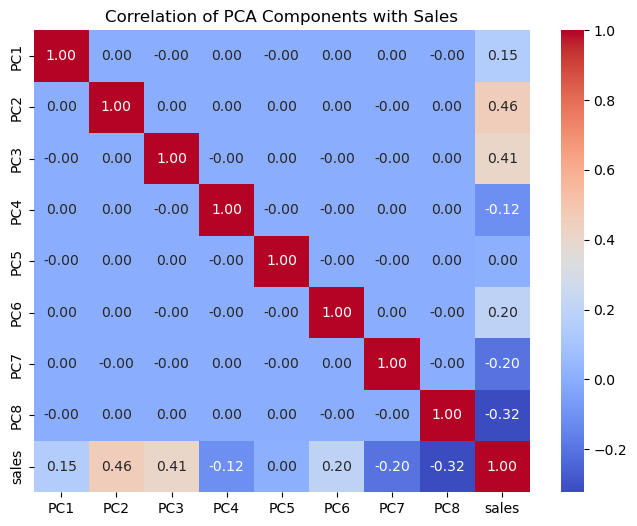

In [248]:
# Double chekcing the correclations of each principle component to the sales.
pca_cleaned_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
pca_cleaned_df['sales'] = cleaned_df['sales'].values

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(pca_cleaned_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of PCA Components with Sales")
plt.show()

In [249]:
# Loadings provide a numerical explanation that precisely indicate which features contribute most and least to the question asked.
# PC1 represents the number 1 principle components (the most important factors) that drive the variation.
# PC2 represents the second priciple components that drive the variation, but these components are not the same as presented in PC1.
# The list goes on.

loadings = pd.DataFrame(
    pca.components_.T, 
    index=features, 
    columns=[f"PC{i+1}" for i in range(pca.n_components_)])

print(loadings)


                                     PC1       PC2       PC3       PC4  \
cleaned_price                  -0.238203  0.533566  0.243118  0.026203   
stock_quantity                  0.485525  0.255234  0.473936 -0.223053   
number_of_reviews               0.620272  0.179394  0.153689 -0.161429   
average_review_rating_out_of_5 -0.390426  0.153086  0.287998 -0.088808   
item_weight_in_kg               0.038501  0.321415  0.187849  0.830230   
recommended_minimum_age_years  -0.386371  0.358895  0.171814 -0.370564   
month_sin                      -0.125534 -0.398587  0.493523 -0.162169   
month_cos                      -0.061897 -0.451178  0.548946  0.250431   

                                     PC5       PC6       PC7       PC8  
cleaned_price                  -0.243921  0.537802 -0.497969 -0.045519  
stock_quantity                  0.232634 -0.128624  0.062108 -0.591805  
number_of_reviews              -0.092972  0.042845 -0.012228  0.723030  
average_review_rating_out_of_5  0.638415 

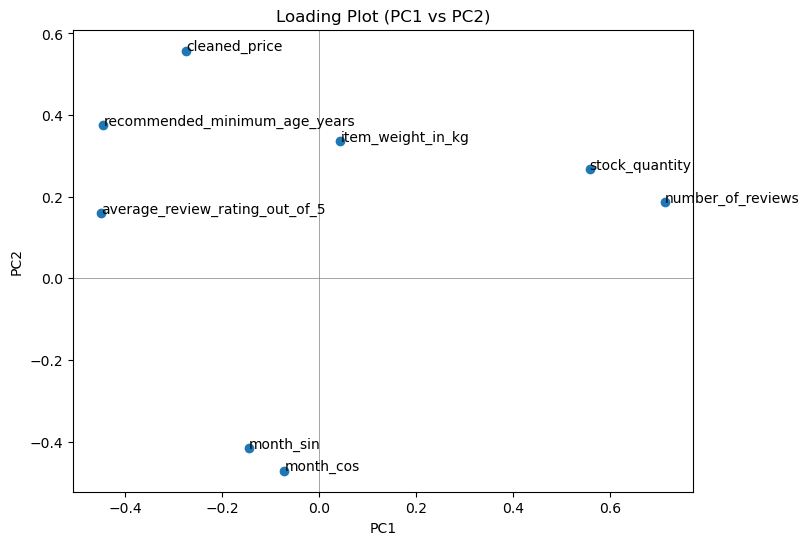

In [ ]:
# A plot for PC1 and PC2 loading. 
# Each dot represents a feature. 
# Features that are closer to 0 are the weak contributors, while those farther from 0 are strong contributors.
# Features that are closer to a PC contribute more strongly to that PC.
# Features that are close to each other have similar contribution patterns. 

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

plt.figure(figsize=(8,6))
plt.scatter(loadings[:,0], loadings[:,1])

for i, feature in enumerate(features):
    plt.text(loadings[i,0], loadings[i,1], feature)

plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Loading Plot (PC1 vs PC2)")
plt.show()
